Loading images...
Nuclei mask shape: (1024, 1024), unique IDs: 256
Membrane mask shape: (1024, 1024), values: [0 1]
Analyzing nuclei properties...
Dilating nuclei with radius 3...
Finding overlapping nuclei...
Found 70 potentially overlapping nuclei pairs
Merging nuclei based on membrane barriers...
Processing 70 overlapping nuclei pairs...


  0%|          | 0/70 [00:00<?, ?it/s]

Merging nuclei 206 and 209 (blocked lines: 0/15)
Merging nuclei 247 and 249 (blocked lines: 0/15)
Merging nuclei 173 and 181 (blocked lines: 0/15)
Merging nuclei 44 and 48 (blocked lines: 0/15)
Merging nuclei 33 and 34 (blocked lines: 0/15)
Relabeling mask to have consecutive IDs...
Original nuclei count: 256
Final cell count: 251


/usr/local/lib/python3.11/dist-packages/skimage/_shared/utils.py:328: UserWarning: cell_segmentation_results/segmented_cells.tif is a low contrast image
  return func(*args, **kwargs)


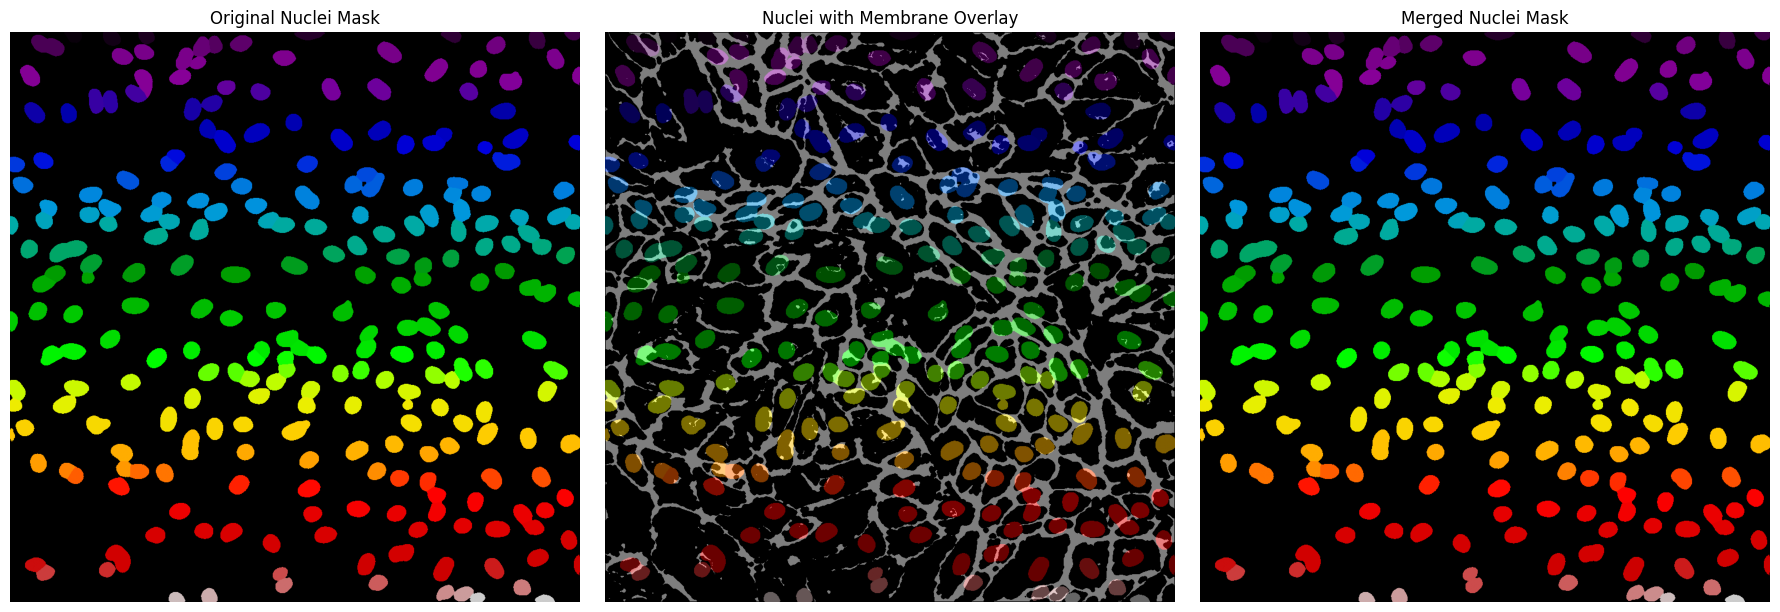

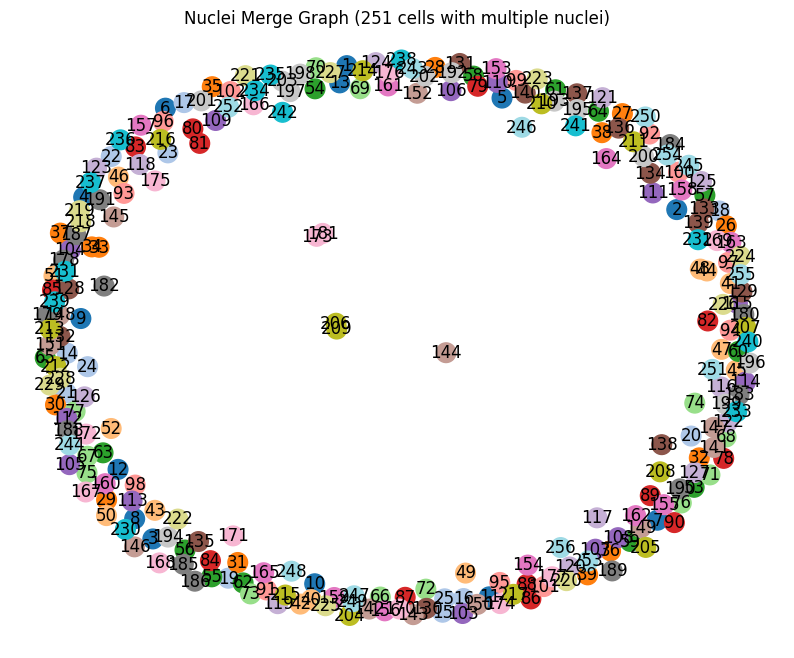

Cell segmentation completed!


In [13]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage
from skimage import io, measure, segmentation, morphology, draw
import networkx as nx
from tqdm.notebook import tqdm
import os

def load_images(nuclei_path, membrane_path):
    """
    Load nuclei and membrane images.

    Parameters:
    -----------
    nuclei_path : str
        Path to the nuclei mask image
    membrane_path : str
        Path to the membrane mask image

    Returns:
    --------
    nuclei_mask : ndarray
        Labeled nuclei mask where each nucleus has a unique integer ID
    membrane_mask : ndarray
        Binary membrane mask (1 for membrane, 0 for background)
    """
    nuclei_mask = io.imread(nuclei_path)
    membrane_mask = io.imread(membrane_path)

    # Ensure membrane mask is binary
    if membrane_mask.max() > 1:
        membrane_mask = (membrane_mask > 0).astype(np.uint8)

    return nuclei_mask, membrane_mask

def get_nuclei_properties(nuclei_mask):
    """
    Get properties of each nucleus in the mask.

    Parameters:
    -----------
    nuclei_mask : ndarray
        Labeled nuclei mask

    Returns:
    --------
    nuclei_props : list
        List of region properties for each nucleus
    """
    return measure.regionprops(nuclei_mask)

def dilate_nuclei_mask(nuclei_mask, dilation_radius=3):
    """
    Dilate each nucleus in the mask to detect proximity.

    Parameters:
    -----------
    nuclei_mask : ndarray
        Labeled nuclei mask
    dilation_radius : int
        Radius for dilation operation

    Returns:
    --------
    dilated_masks : dict
        Dictionary mapping nucleus ID to its dilated mask
    """
    dilated_masks = {}
    for i in np.unique(nuclei_mask):
        if i == 0:  # Skip background
            continue

        # Create binary mask for this nucleus
        binary_mask = (nuclei_mask == i).astype(np.uint8)

        # Dilate the mask
        dilated_binary_mask = ndimage.binary_dilation(
            binary_mask,
            iterations=dilation_radius
        ).astype(np.uint8)

        dilated_masks[i] = dilated_binary_mask

    return dilated_masks

def find_overlapping_nuclei(dilated_masks, nuclei_props):
    """
    Find pairs of nuclei whose dilated masks overlap.

    Parameters:
    -----------
    dilated_masks : dict
        Dictionary of dilated masks for each nucleus
    nuclei_props : list
        List of region properties for each nucleus

    Returns:
    --------
    overlapping_pairs : list
        List of tuples (id1, id2, centroid1, centroid2) for overlapping nuclei
    """
    nuclei_ids = list(dilated_masks.keys())
    overlapping_pairs = []

    # Create mapping from nucleus ID to its centroid
    centroids = {prop.label: prop.centroid for prop in nuclei_props}

    for i, id1 in enumerate(nuclei_ids):
        for id2 in nuclei_ids[i+1:]:
            # Check if dilated masks overlap
            if np.any(dilated_masks[id1] * dilated_masks[id2]):
                overlapping_pairs.append((
                    id1, id2,
                    centroids[id1], centroids[id2]
                ))

    # Sort by proximity (using centroid distance as an approximation)
    overlapping_pairs.sort(key=lambda x: np.sqrt(
        (x[2][0] - x[3][0])**2 + (x[2][1] - x[3][1])**2
    ))

    return overlapping_pairs

def create_line_corridor(centroid1, centroid2, corridor_width=15):
    """
    Create a corridor of parallel lines between two centroids.

    Parameters:
    -----------
    centroid1, centroid2 : tuple
        Centroids of two nuclei (y, x)
    corridor_width : int
        Number of parallel lines in the corridor

    Returns:
    --------
    lines : list
        List of lines, where each line is a list of points (y, x)
    """
    # Convert to integer coordinates
    y1, x1 = int(centroid1[0]), int(centroid1[1])
    y2, x2 = int(centroid2[0]), int(centroid2[1])

    # Calculate direction vector and perpendicular vector
    dx, dy = x2 - x1, y2 - y1
    length = np.sqrt(dx**2 + dy**2)

    if length == 0:  # Handle the case where centroids are at the same position
        return []

    # Normalize direction vector
    dx, dy = dx / length, dy / length

    # Calculate perpendicular vector (normalized)
    px, py = -dy, dx

    # Half the corridor width
    half_width = corridor_width // 2

    # Generate parallel lines
    lines = []
    for i in range(-half_width, half_width + 1):
        # Calculate offset for this line
        offset_x, offset_y = i * px, i * py

        # Calculate start and end points for this line
        start_y, start_x = y1 + offset_y, x1 + offset_x
        end_y, end_x = y2 + offset_y, x2 + offset_x

        # Use Bresenham's line algorithm to get points along the line
        rr, cc = draw.line(int(start_y), int(start_x), int(end_y), int(end_x))

        # Add line points to the list
        line_points = list(zip(rr, cc))
        lines.append(line_points)

    return lines

def check_membrane_barrier(lines, membrane_mask, threshold=0.5):
    """
    Check if there's a membrane barrier between two nuclei.

    Parameters:
    -----------
    lines : list
        List of lines in the corridor
    membrane_mask : ndarray
        Binary membrane mask
    threshold : float
        Fraction of lines that must be blocked to consider it a barrier

    Returns:
    --------
    has_barrier : bool
        True if a membrane barrier exists, False otherwise
    blocked_count : int
        Number of lines that are blocked by a membrane
    """
    # Skip empty lines list (could happen if centroids are at the same position)
    if not lines:
        return False, 0

    blocked_lines = 0

    for line_points in lines:
        # Check each line independently
        line_blocked = False

        for y, x in line_points:
            # Check if point is within image bounds
            if (0 <= y < membrane_mask.shape[0] and
                0 <= x < membrane_mask.shape[1]):

                # Check if point is on a membrane
                if membrane_mask[y, x] == 1:
                    line_blocked = True
                    break

        if line_blocked:
            blocked_lines += 1

    # Check if enough lines are blocked to consider it a barrier
    has_barrier = (blocked_lines / len(lines)) >= threshold

    return has_barrier, blocked_lines

def merge_nuclei(nuclei_mask, overlapping_pairs, membrane_mask, corridor_width=15, barrier_threshold=0.5):
    """
    Merge nuclei that belong to the same cell based on membrane barriers.

    Parameters:
    -----------
    nuclei_mask : ndarray
        Labeled nuclei mask
    overlapping_pairs : list
        List of overlapping nuclei pairs
    membrane_mask : ndarray
        Binary membrane mask
    corridor_width : int
        Width of the corridor for barrier detection
    barrier_threshold : float
        Threshold for determining if a barrier exists

    Returns:
    --------
    merged_mask : ndarray
        Nuclei mask after merging
    merge_graph : networkx.Graph
        Graph representing merge operations
    """
    # Create a copy of the nuclei mask
    merged_mask = nuclei_mask.copy()

    # Create a graph to track merges
    merge_graph = nx.Graph()

    # Add all nuclei as nodes
    for label in np.unique(nuclei_mask):
        if label > 0:  # Skip background
            merge_graph.add_node(label)

    print(f"Processing {len(overlapping_pairs)} overlapping nuclei pairs...")

    # Process each overlapping pair
    for id1, id2, centroid1, centroid2 in tqdm(overlapping_pairs):
        # Check if these IDs still exist (haven't been merged already)
        if id1 not in np.unique(merged_mask) or id2 not in np.unique(merged_mask):
            continue

        # Create corridor of lines between centroids
        lines = create_line_corridor(centroid1, centroid2, corridor_width)

        # Check if there's a membrane barrier
        has_barrier, blocked_count = check_membrane_barrier(
            lines, membrane_mask, barrier_threshold
        )

        # If no barrier, merge the nuclei
        if not has_barrier:
            print(f"Merging nuclei {id1} and {id2} (blocked lines: {blocked_count}/{len(lines)})")

            # Always merge higher ID into lower ID
            source_id = max(id1, id2)
            target_id = min(id1, id2)

            # Update the mask
            merged_mask[merged_mask == source_id] = target_id

            # Add edge in the merge graph
            merge_graph.add_edge(source_id, target_id)

    return merged_mask, merge_graph

def relabel_mask(mask):
    """
    Relabel a mask to have consecutive IDs.

    Parameters:
    -----------
    mask : ndarray
        Input mask

    Returns:
    --------
    relabeled_mask : ndarray
        Mask with consecutive IDs
    """
    # Get unique IDs (excluding 0/background)
    unique_ids = np.unique(mask)
    unique_ids = unique_ids[unique_ids > 0]

    # Create mapping from old IDs to new IDs
    id_mapping = {old_id: new_id for new_id, old_id in enumerate(unique_ids, 1)}

    # Create new mask
    relabeled_mask = np.zeros_like(mask)

    # Apply mapping
    for old_id, new_id in id_mapping.items():
        relabeled_mask[mask == old_id] = new_id

    return relabeled_mask

def visualize_results(nuclei_mask, membrane_mask, merged_mask, save_path=None):
    """
    Visualize the segmentation results.

    Parameters:
    -----------
    nuclei_mask : ndarray
        Original nuclei mask
    membrane_mask : ndarray
        Membrane mask
    merged_mask : ndarray
        Nuclei mask after merging
    save_path : str, optional
        Path to save the visualization
    """
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    # Plot original nuclei mask
    axes[0].imshow(nuclei_mask, cmap='nipy_spectral')
    axes[0].set_title('Original Nuclei Mask')
    axes[0].axis('off')

    # Plot membrane mask overlay
    axes[1].imshow(nuclei_mask, cmap='nipy_spectral')
    axes[1].imshow(membrane_mask, cmap='gray', alpha=0.5)
    axes[1].set_title('Nuclei with Membrane Overlay')
    axes[1].axis('off')

    # Plot merged mask
    axes[2].imshow(merged_mask, cmap='nipy_spectral')
    axes[2].set_title('Merged Nuclei Mask')
    axes[2].axis('off')

    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')

    plt.show()

def visualize_merge_graph(merge_graph, save_path=None):
    """
    Visualize the merge graph.

    Parameters:
    -----------
    merge_graph : networkx.Graph
        Graph representing merge operations
    save_path : str, optional
        Path to save the visualization
    """
    plt.figure(figsize=(10, 8))

    # Get connected components (each represents a merged cell)
    components = list(nx.connected_components(merge_graph))

    # Assign a different color to each component
    color_map = {}
    for i, component in enumerate(components):
        for node in component:
            color_map[node] = i

    # Set node colors
    node_colors = [color_map.get(node, len(components)) for node in merge_graph.nodes()]

    # Draw the graph
    pos = nx.spring_layout(merge_graph, seed=42)
    nx.draw_networkx(
        merge_graph, pos,
        node_color=node_colors,
        cmap=plt.cm.tab20,
        node_size=200,
        with_labels=True
    )

    plt.title(f'Nuclei Merge Graph ({len(components)} cells with multiple nuclei)')
    plt.axis('off')

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')

    plt.show()

def segment_cells(nuclei_path, membrane_path, proximity_threshold=3,
                 corridor_width=15, barrier_threshold=0.5, output_dir=None):
    """
    Main function to segment cells using nuclei and membrane images.

    Parameters:
    -----------
    nuclei_path : str
        Path to nuclei mask image
    membrane_path : str
        Path to membrane mask image
    proximity_threshold : int
        Dilation radius for proximity detection
    corridor_width : int
        Width of the corridor for barrier detection
    barrier_threshold : float
        Threshold for determining if a barrier exists
    output_dir : str, optional
        Directory to save outputs

    Returns:
    --------
    merged_mask : ndarray
        Final segmented cell mask
    """
    print("Loading images...")
    nuclei_mask, membrane_mask = load_images(nuclei_path, membrane_path)

    print(f"Nuclei mask shape: {nuclei_mask.shape}, unique IDs: {len(np.unique(nuclei_mask)) - 1}")
    print(f"Membrane mask shape: {membrane_mask.shape}, values: {np.unique(membrane_mask)}")

    print("Analyzing nuclei properties...")
    nuclei_props = get_nuclei_properties(nuclei_mask)

    print(f"Dilating nuclei with radius {proximity_threshold}...")
    dilated_masks = dilate_nuclei_mask(nuclei_mask, proximity_threshold)

    print("Finding overlapping nuclei...")
    overlapping_pairs = find_overlapping_nuclei(dilated_masks, nuclei_props)
    print(f"Found {len(overlapping_pairs)} potentially overlapping nuclei pairs")

    print("Merging nuclei based on membrane barriers...")
    merged_mask, merge_graph = merge_nuclei(
        nuclei_mask, overlapping_pairs, membrane_mask,
        corridor_width, barrier_threshold
    )

    print("Relabeling mask to have consecutive IDs...")
    final_mask = relabel_mask(merged_mask)

    print(f"Original nuclei count: {len(np.unique(nuclei_mask)) - 1}")
    print(f"Final cell count: {len(np.unique(final_mask)) - 1}")

    # Save outputs if directory is provided
    if output_dir:
        os.makedirs(output_dir, exist_ok=True)

        # Save final mask
        io.imsave(os.path.join(output_dir, 'segmented_cells.tif'),
                  final_mask.astype(np.uint16))

        # Save visualizations
        visualize_results(
            nuclei_mask, membrane_mask, final_mask,
            save_path=os.path.join(output_dir, 'segmentation_results.png')
        )

        visualize_merge_graph(
            merge_graph,
            save_path=os.path.join(output_dir, 'merge_graph.png')
        )
    else:
        # Display visualizations
        visualize_results(nuclei_mask, membrane_mask, final_mask)
        visualize_merge_graph(merge_graph)

    return final_mask

# Example usage
if __name__ == "__main__":
    # Paths to input images
    nuclei_path = 'nuclei.tif'
    membrane_path = 'membrane.tif'

    # Parameters
    proximity_threshold = 3  # Dilation radius for proximity detection
    corridor_width = 15      # Number of parallel lines in corridor
    barrier_threshold = 0.5  # Fraction of lines that must be blocked to consider it a barrier

    # Create output directory
    output_dir = 'cell_segmentation_results'

    # Run segmentation
    segmented_cells = segment_cells(
        nuclei_path, membrane_path,
        proximity_threshold=proximity_threshold,
        corridor_width=corridor_width,
        barrier_threshold=barrier_threshold,
        output_dir=output_dir
    )

    print("Cell segmentation completed!")

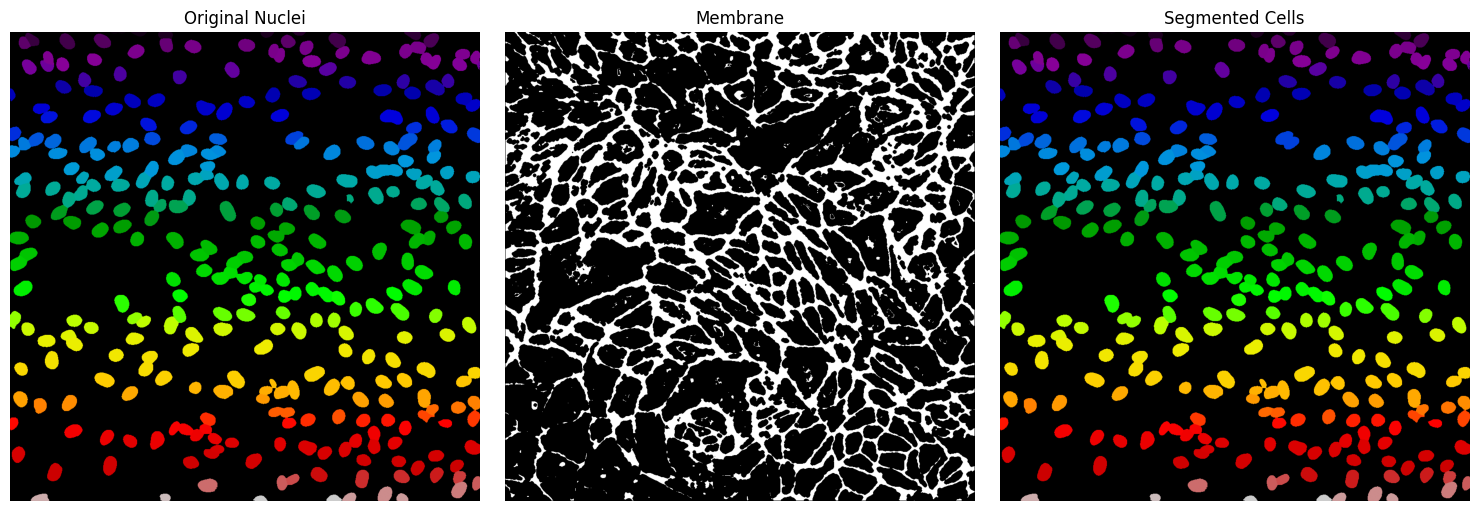

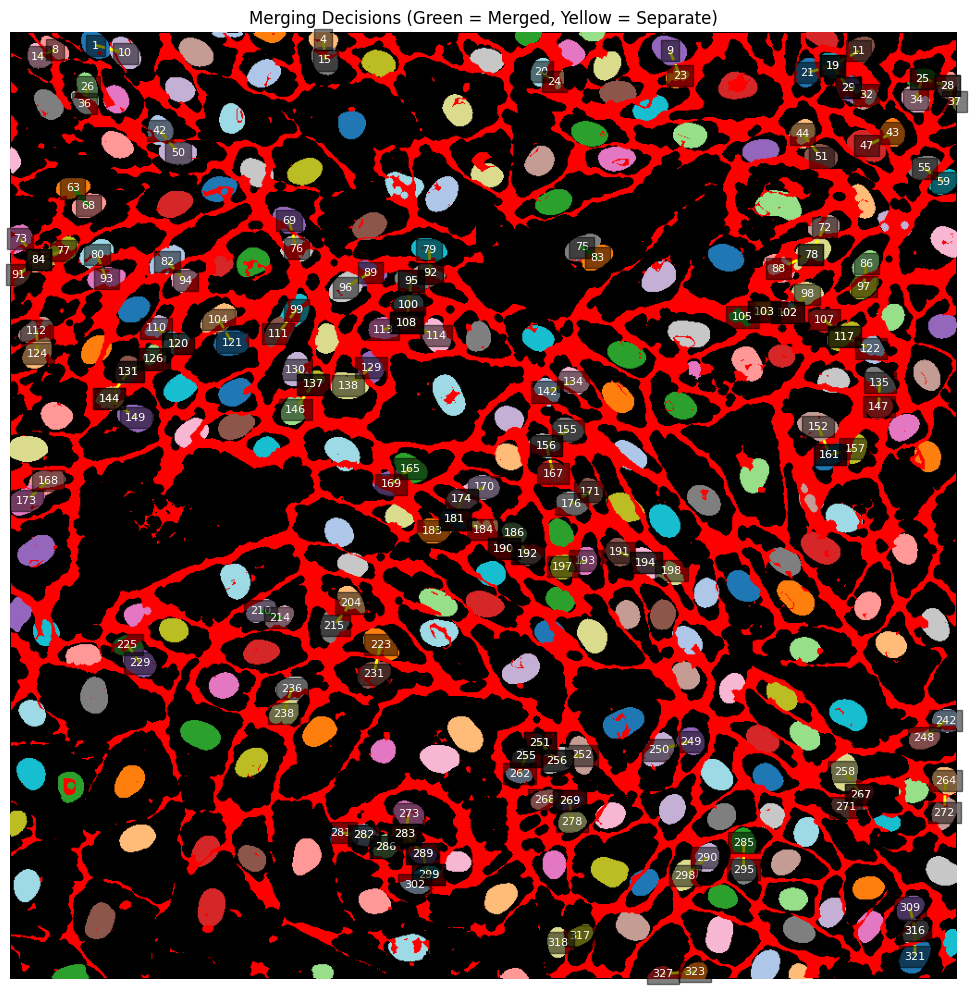

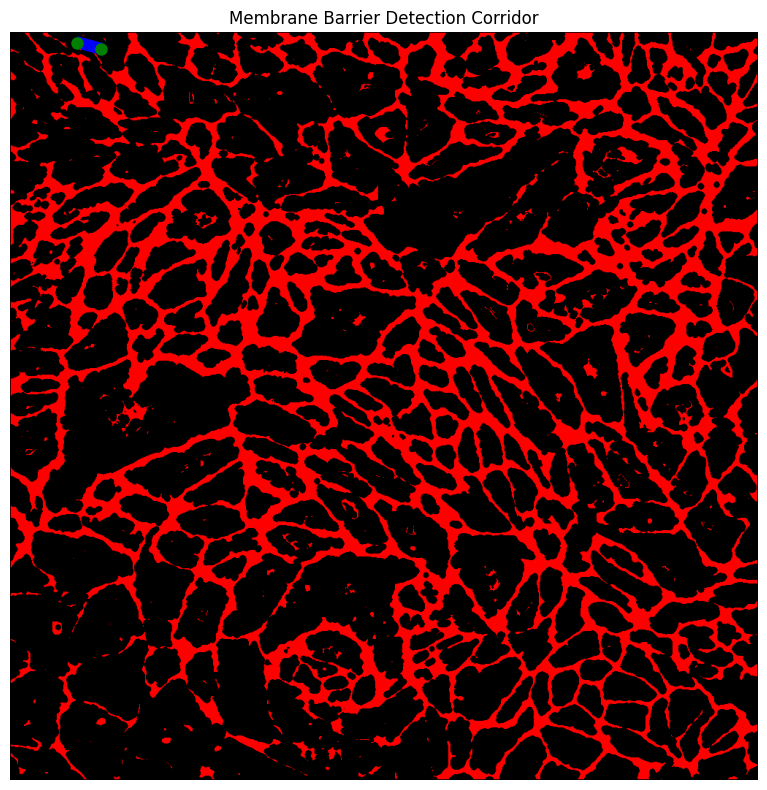

Original nuclei count: 328
Segmented cell count: 325
Number of multinucleated cells: 3
Cell 1: Nuclei {np.uint32(68), np.uint32(63)} were merged
Cell 2: Nuclei {np.uint32(83), np.uint32(75)} were merged
Cell 3: Nuclei {np.uint32(210), np.uint32(214)} were merged


/usr/local/lib/python3.11/dist-packages/skimage/_shared/utils.py:328: UserWarning: segmented_cells.tif is a low contrast image
  return func(*args, **kwargs)


In [12]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import io, measure, morphology
from scipy import ndimage
import networkx as nx
from skimage.draw import line
import os

class UnionFind:
    """Union-find data structure for efficient merging of nuclei."""

    def __init__(self, n):
        """Initialize with n elements."""
        self.parent = list(range(n))
        self.rank = [0] * n

    def find(self, x):
        """Find the root of x with path compression."""
        if self.parent[x] != x:
            self.parent[x] = self.find(self.parent[x])
        return self.parent[x]

    def union(self, x, y):
        """Merge the sets containing x and y."""
        root_x = self.find(x)
        root_y = self.find(y)

        if root_x == root_y:
            return

        # Union by rank
        if self.rank[root_x] < self.rank[root_y]:
            self.parent[root_x] = root_y
        elif self.rank[root_x] > self.rank[root_y]:
            self.parent[root_y] = root_x
        else:
            self.parent[root_y] = root_x
            self.rank[root_x] += 1

def load_images(nuclei_path, membrane_path):
    """
    Load nuclei and membrane images.

    Parameters:
    -----------
    nuclei_path : str
        Path to the nuclei mask image (labeled)
    membrane_path : str
        Path to the membrane mask image (binary)

    Returns:
    --------
    nuclei_mask : ndarray
        Labeled nuclei mask
    membrane_mask : ndarray
        Binary membrane mask
    """
    nuclei_mask = io.imread(nuclei_path)
    membrane_mask = io.imread(membrane_path)

    # Ensure membrane mask is binary
    if membrane_mask.max() > 1:
        membrane_mask = (membrane_mask > 0).astype(np.uint8)

    return nuclei_mask, membrane_mask

def get_nucleus_properties(nuclei_mask):
    """
    Get properties of each nucleus in the mask.

    Parameters:
    -----------
    nuclei_mask : ndarray
        Labeled nuclei mask

    Returns:
    --------
    props : list
        List of region properties for each nucleus
    """
    return measure.regionprops(nuclei_mask)

def find_neighboring_nuclei(nuclei_mask, proximity_threshold=3):
    """
    Find neighboring nuclei using mask dilation.

    Parameters:
    -----------
    nuclei_mask : ndarray
        Labeled nuclei mask
    proximity_threshold : int
        Dilation radius to determine proximity

    Returns:
    --------
    neighbor_pairs : list
        List of neighboring nuclei pairs (ID1, ID2)
    """
    # Get unique nucleus IDs (excluding background 0)
    nucleus_ids = np.unique(nuclei_mask)[1:]

    # Initialize list to store neighboring pairs
    neighbor_pairs = []

    # Create a binary mask for each nucleus, dilate it, and check overlap with others
    for i, id1 in enumerate(nucleus_ids):
        mask1 = (nuclei_mask == id1).astype(np.uint8)
        dilated_mask1 = morphology.binary_dilation(mask1, morphology.disk(proximity_threshold))

        for id2 in nucleus_ids[i+1:]:
            mask2 = (nuclei_mask == id2).astype(np.uint8)

            # Check if dilated mask1 overlaps with mask2
            if np.any(dilated_mask1 & mask2):
                neighbor_pairs.append((id1, id2))

    return neighbor_pairs

def check_membrane_barrier(centroid1, centroid2, membrane_mask, corridor_width=15, membrane_threshold=0.5):
    """
    Check if there's a complete membrane barrier between two nuclei.

    Parameters:
    -----------
    centroid1 : tuple
        (y, x) coordinates of the first nucleus centroid
    centroid2 : tuple
        (y, x) coordinates of the second nucleus centroid
    membrane_mask : ndarray
        Binary membrane mask
    corridor_width : int
        Number of parallel lines to check
    membrane_threshold : float
        Threshold for determining if a barrier exists (0.0-1.0)

    Returns:
    --------
    has_barrier : bool
        True if a complete membrane barrier exists, False otherwise
    """
    y1, x1 = centroid1
    y2, x2 = centroid2

    # Calculate corridor parameters
    corridor_dir = np.array([x2 - x1, y2 - y1])
    corridor_length = np.sqrt(np.sum(corridor_dir**2))
    corridor_dir = corridor_dir / corridor_length

    # Calculate perpendicular direction for corridor width
    perp_dir = np.array([-corridor_dir[1], corridor_dir[0]])

    # Initialize counters
    lines_with_barrier = 0
    total_lines = 0

    # Check different lines in the corridor
    offset_range = np.linspace(-(corridor_width//2), corridor_width//2, corridor_width)

    for offset in offset_range:
        # Calculate offset start and end points
        start_y = int(y1 + offset * perp_dir[1])
        start_x = int(x1 + offset * perp_dir[0])
        end_y = int(y2 + offset * perp_dir[1])
        end_x = int(x2 + offset * perp_dir[0])

        # Get coordinates of the line
        line_coords = line(start_y, start_x, end_y, end_x)

        # Check if line is within image bounds
        y_valid = (line_coords[0] >= 0) & (line_coords[0] < membrane_mask.shape[0])
        x_valid = (line_coords[1] >= 0) & (line_coords[1] < membrane_mask.shape[1])
        valid_coords = y_valid & x_valid

        if np.any(valid_coords):
            total_lines += 1
            line_coords = (line_coords[0][valid_coords], line_coords[1][valid_coords])

            # Check if membrane is present along the line
            membrane_values = membrane_mask[line_coords]
            if np.any(membrane_values > 0):
                lines_with_barrier += 1

    # Determine if there's a complete barrier
    if total_lines > 0:
        barrier_ratio = lines_with_barrier / total_lines
        has_barrier = barrier_ratio >= membrane_threshold
    else:
        has_barrier = False

    return has_barrier

def merge_nuclei(nuclei_mask, neighbor_pairs, membrane_mask, corridor_width=15, membrane_threshold=0.5):
    """
    Merge nuclei that belong to the same cell based on membrane barriers.

    Parameters:
    -----------
    nuclei_mask : ndarray
        Labeled nuclei mask
    neighbor_pairs : list
        List of neighboring nuclei pairs (ID1, ID2)
    membrane_mask : ndarray
        Binary membrane mask
    corridor_width : int
        Number of parallel lines to check
    membrane_threshold : float
        Threshold for determining if a barrier exists (0.0-1.0)

    Returns:
    --------
    merged_mask : ndarray
        Updated nuclei mask after merging
    merge_graph : networkx.Graph
        Graph representing merged nuclei
    merged_ids : dict
        Mapping from original nucleus IDs to merged IDs
    """
    # Create a copy of the nuclei mask
    merged_mask = nuclei_mask.copy()

    # Get region properties for all nuclei
    props = get_nucleus_properties(nuclei_mask)

    # Create a mapping of nucleus ID to centroid
    id_to_centroid = {prop.label: prop.centroid for prop in props}

    # Create a graph to track merges
    merge_graph = nx.Graph()
    for nucleus_id in np.unique(nuclei_mask)[1:]:
        merge_graph.add_node(nucleus_id)

    # Create a union-find data structure to track merges
    nucleus_ids = np.unique(nuclei_mask)[1:]
    id_to_index = {id: i for i, id in enumerate(nucleus_ids)}
    uf = UnionFind(len(nucleus_ids))

    # Process each neighboring pair
    for id1, id2 in neighbor_pairs:
        # Get indices
        idx1 = id_to_index[id1]
        idx2 = id_to_index[id2]

        # Skip if they're already merged
        if uf.find(idx1) == uf.find(idx2):
            continue

        # Check if there's a membrane barrier between them
        centroid1 = id_to_centroid[id1]
        centroid2 = id_to_centroid[id2]
        has_barrier = check_membrane_barrier(centroid1, centroid2, membrane_mask,
                                           corridor_width, membrane_threshold)

        # If no barrier, merge the nuclei
        if not has_barrier:
            # Add edge to graph
            merge_graph.add_edge(id1, id2)

            # Merge in union-find
            uf.union(idx1, idx2)

    # Create a mapping from old IDs to merged IDs
    merged_ids = {}
    for id in nucleus_ids:
        idx = id_to_index[id]
        root_idx = uf.find(idx)
        root_id = nucleus_ids[root_idx]
        merged_ids[id] = root_id

    # Apply the mapping to the mask
    for old_id, new_id in merged_ids.items():
        merged_mask[nuclei_mask == old_id] = new_id

    # Relabel the mask to have consecutive IDs
    merged_mask, _, _ = relabel_consecutive(merged_mask)

    return merged_mask, merge_graph, merged_ids

def relabel_consecutive(mask):
    """
    Relabel a mask to have consecutive IDs starting from 1.

    Parameters:
    -----------
    mask : ndarray
        Input labeled mask

    Returns:
    --------
    relabeled_mask : ndarray
        Relabeled mask with consecutive IDs
    forward_map : dict
        Mapping from old IDs to new IDs
    inverse_map : dict
        Mapping from new IDs to old IDs
    """
    # Get unique IDs (excluding background 0)
    unique_ids = np.unique(mask)[1:]

    # Create mapping
    forward_map = {old_id: new_id+1 for new_id, old_id in enumerate(unique_ids)}
    inverse_map = {new_id+1: old_id for new_id, old_id in enumerate(unique_ids)}

    # Initialize relabeled mask
    relabeled_mask = np.zeros_like(mask)

    # Apply mapping
    for old_id, new_id in forward_map.items():
        relabeled_mask[mask == old_id] = new_id

    return relabeled_mask, forward_map, inverse_map

def segment_cells(nuclei_mask, membrane_mask, proximity_threshold=3,
                 corridor_width=15, membrane_threshold=0.5):
    """
    Segment cells by merging nuclei that belong to the same cell.

    Parameters:
    -----------
    nuclei_mask : ndarray
        Labeled nuclei mask
    membrane_mask : ndarray
        Binary membrane mask
    proximity_threshold : int
        Dilation radius to determine proximity
    corridor_width : int
        Number of parallel lines to check
    membrane_threshold : float
        Threshold for determining if a barrier exists (0.0-1.0)

    Returns:
    --------
    cell_mask : ndarray
        Segmented cell mask
    merge_graph : networkx.Graph
        Graph representing merged nuclei
    merged_ids : dict
        Mapping from original nucleus IDs to merged IDs
    neighbor_pairs : list
        List of neighboring nuclei pairs
    """
    # Find neighboring nuclei
    neighbor_pairs = find_neighboring_nuclei(nuclei_mask, proximity_threshold)

    # Merge nuclei
    cell_mask, merge_graph, merged_ids = merge_nuclei(
        nuclei_mask, neighbor_pairs, membrane_mask, corridor_width, membrane_threshold
    )

    return cell_mask, merge_graph, merged_ids, neighbor_pairs

def visualize_results(nuclei_mask, membrane_mask, cell_mask, figsize=(15, 5)):
    """
    Visualize the segmentation results.

    Parameters:
    -----------
    nuclei_mask : ndarray
        Original labeled nuclei mask
    membrane_mask : ndarray
        Binary membrane mask
    cell_mask : ndarray
        Segmented cell mask
    figsize : tuple
        Figure size
    """
    fig, axes = plt.subplots(1, 3, figsize=figsize)

    # Display original nuclei mask
    axes[0].imshow(nuclei_mask, cmap='nipy_spectral')
    axes[0].set_title('Original Nuclei')
    axes[0].axis('off')

    # Display membrane mask
    axes[1].imshow(membrane_mask, cmap='gray')
    axes[1].set_title('Membrane')
    axes[1].axis('off')

    # Display segmented cell mask
    axes[2].imshow(cell_mask, cmap='nipy_spectral')
    axes[2].set_title('Segmented Cells')
    axes[2].axis('off')

    plt.tight_layout()
    plt.show()

def visualize_merging_decisions(nuclei_mask, membrane_mask, merged_ids, neighbor_pairs,
                              id_to_centroid, figsize=(10, 10)):
    """
    Visualize the merging decisions for neighboring nuclei.

    Parameters:
    -----------
    nuclei_mask : ndarray
        Original labeled nuclei mask
    membrane_mask : ndarray
        Binary membrane mask
    merged_ids : dict
        Mapping from original nucleus IDs to merged IDs
    neighbor_pairs : list
        List of neighboring nuclei pairs (ID1, ID2)
    id_to_centroid : dict
        Mapping of nucleus ID to centroid
    figsize : tuple
        Figure size
    """
    # Create a color overlay
    overlay = np.zeros((*nuclei_mask.shape, 3), dtype=np.uint8)

    # Set different colors for nuclei
    for i, id in enumerate(np.unique(nuclei_mask)[1:]):
        color = np.array(plt.cm.tab20(i % 20)[:3]) * 255
        overlay[nuclei_mask == id] = color

    # Add membrane in red
    overlay[membrane_mask > 0] = [255, 0, 0]

    # Draw lines between neighboring nuclei
    plt.figure(figsize=figsize)
    plt.imshow(overlay)

    for id1, id2 in neighbor_pairs:
        # Check if they were merged
        merged = merged_ids[id1] == merged_ids[id2]

        # Get centroids
        y1, x1 = id_to_centroid[id1]
        y2, x2 = id_to_centroid[id2]

        # Draw line
        color = 'lime' if merged else 'yellow'
        plt.plot([x1, x2], [y1, y2], color=color, linewidth=2,
                 linestyle='-' if merged else '--')

        # Add labels
        plt.text(x1, y1, str(id1), color='white', fontsize=8,
                ha='center', va='center', bbox=dict(facecolor='black', alpha=0.5))
        plt.text(x2, y2, str(id2), color='white', fontsize=8,
                ha='center', va='center', bbox=dict(facecolor='black', alpha=0.5))

    plt.title('Merging Decisions (Green = Merged, Yellow = Separate)')
    plt.axis('off')
    plt.tight_layout()
    plt.show()

def visualize_corridor(centroid1, centroid2, membrane_mask, corridor_width=15, figsize=(8, 8)):
    """
    Visualize the corridor between two nuclei.

    Parameters:
    -----------
    centroid1 : tuple
        (y, x) coordinates of the first nucleus centroid
    centroid2 : tuple
        (y, x) coordinates of the second nucleus centroid
    membrane_mask : ndarray
        Binary membrane mask
    corridor_width : int
        Number of parallel lines to check
    figsize : tuple
        Figure size
    """
    y1, x1 = centroid1
    y2, x2 = centroid2

    # Calculate corridor parameters
    corridor_dir = np.array([x2 - x1, y2 - y1])
    corridor_length = np.sqrt(np.sum(corridor_dir**2))
    corridor_dir = corridor_dir / corridor_length

    # Calculate perpendicular direction for corridor width
    perp_dir = np.array([-corridor_dir[1], corridor_dir[0]])

    # Create an RGB image from the membrane mask
    rgb_image = np.zeros((*membrane_mask.shape, 3), dtype=np.uint8)
    rgb_image[..., 0] = membrane_mask * 255  # Red channel for membrane

    # Draw the corridor lines
    offset_range = np.linspace(-(corridor_width//2), corridor_width//2, corridor_width)

    plt.figure(figsize=figsize)
    plt.imshow(rgb_image)

    for offset in offset_range:
        # Calculate offset start and end points
        start_y = int(y1 + offset * perp_dir[1])
        start_x = int(x1 + offset * perp_dir[0])
        end_y = int(y2 + offset * perp_dir[1])
        end_x = int(x2 + offset * perp_dir[0])

        # Draw the line
        plt.plot([start_x, end_x], [start_y, end_y], 'b-', linewidth=1)

    # Mark the centroids
    plt.plot(x1, y1, 'go', markersize=8)
    plt.plot(x2, y2, 'go', markersize=8)

    plt.title('Membrane Barrier Detection Corridor')
    plt.axis('off')
    plt.tight_layout()
    plt.show()

def main():
    """
    Main function to run the cell segmentation algorithm.
    """
    # Define paths
    nuclei_path = "nuclei.tif"
    membrane_path = "membrane.tif"

    # Load images
    nuclei_mask, membrane_mask = load_images(nuclei_path, membrane_path)

    # Set parameters
    proximity_threshold = 3
    corridor_width = 15
    membrane_threshold = 0.5

    # Segment cells
    cell_mask, merge_graph, merged_ids, neighbor_pairs = segment_cells(
        nuclei_mask, membrane_mask, proximity_threshold, corridor_width, membrane_threshold
    )

    # Get region properties for visualizing
    props = get_nucleus_properties(nuclei_mask)
    id_to_centroid = {prop.label: prop.centroid for prop in props}

    # Visualize results
    visualize_results(nuclei_mask, membrane_mask, cell_mask)

    # Visualize merging decisions
    visualize_merging_decisions(nuclei_mask, membrane_mask, merged_ids,
                              neighbor_pairs, id_to_centroid)

    # Visualize corridor for a random neighbor pair (if any)
    if neighbor_pairs:
        id1, id2 = neighbor_pairs[0]
        centroid1 = id_to_centroid[id1]
        centroid2 = id_to_centroid[id2]
        visualize_corridor(centroid1, centroid2, membrane_mask, corridor_width)

    # Save results
    io.imsave("segmented_cells.tif", cell_mask.astype(np.uint16))

    print(f"Original nuclei count: {len(np.unique(nuclei_mask)) - 1}")
    print(f"Segmented cell count: {len(np.unique(cell_mask)) - 1}")

    # Print merge analysis
    connected_components = list(nx.connected_components(merge_graph))
    multinucleated_cells = [comp for comp in connected_components if len(comp) > 1]
    print(f"Number of multinucleated cells: {len(multinucleated_cells)}")

    for i, component in enumerate(multinucleated_cells):
        print(f"Cell {i+1}: Nuclei {component} were merged")

if __name__ == "__main__":
    main()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import binary_dilation, center_of_mass, label
from skimage.morphology import disk
from skimage.draw import line
from skimage import io
from skimage.measure import regionprops
from tqdm.notebook import tqdm
import random
from google.colab.patches import cv2_imshow

# Load the images
nuclei_mask = io.imread('nuclei.tif')
membrane_mask = io.imread('membrane.tif')

# Ensure the membrane mask is binary (0 or 1)
membrane_mask_binary = (membrane_mask > 0).astype(np.uint8)

# Display the original images
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.imshow(nuclei_mask, cmap='nipy_spectral')
plt.title('Nuclei Mask (Labeled)')
plt.colorbar()

plt.subplot(1, 2, 2)
plt.imshow(membrane_mask_binary, cmap='gray')
plt.title('Membrane Mask (Binary)')
plt.colorbar()
plt.tight_layout()
plt.show()

# Function to check membrane interruption between nuclei centroids
def check_membrane_interruption(nucleus1_centroid, nucleus2_centroid, membrane_image, corridor_width=15):
    """
    Check if a membrane completely interrupts the path between two nuclei centroids.

    Parameters:
    -----------
    nucleus1_centroid, nucleus2_centroid : tuple (y, x)
        Coordinates of the nuclei centroids
    membrane_image : 2D numpy array
        Binary image where 1 indicates membrane presence
    corridor_width : int
        Width of the corridor to check (default 15 pixels)

    Returns:
    --------
    is_interrupted : bool
        True if a complete membrane barrier exists across the corridor
    interruption_point : tuple or None
        Coordinates where the path is interrupted (None if no interruption)
    membrane_coverage : float
        Proportion of the corridor covered by membrane (0-1)
    """
    # Create line between centroids
    y0, x0 = nucleus1_centroid
    y1, x1 = nucleus2_centroid
    rr, cc = line(int(y0), int(x0), int(y1), int(x1))
    line_pixels = list(zip(rr, cc))

    # Create mask for the corridor
    path_mask = np.zeros_like(membrane_image, dtype=bool)
    path_mask[rr, cc] = True
    radius = (corridor_width - 1) // 2
    corridor = binary_dilation(path_mask, disk(radius))

    # Calculate overall membrane coverage
    membrane_pixels = np.sum(corridor & membrane_image)
    total_corridor_pixels = np.sum(corridor)
    membrane_coverage = membrane_pixels / total_corridor_pixels

    # Check for complete interruption at each point along the path
    for i in range(1, len(line_pixels)-1):
        point_y, point_x = line_pixels[i]

        # Calculate perpendicular direction
        # Using points before and after to get the direction of the line
        prev_y, prev_x = line_pixels[i-1]
        next_y, next_x = line_pixels[i+1]
        dx = next_x - prev_x
        dy = next_y - prev_y

        # Perpendicular vector (normalized)
        perp_x, perp_y = -dy, dx
        norm = np.sqrt(perp_x**2 + perp_y**2)
        if norm > 0:  # Avoid division by zero
            perp_x, perp_y = perp_x/norm, perp_y/norm

        # Check for complete membrane barrier at this point
        is_interrupted = check_cross_section(
            (point_y, point_x), (perp_y, perp_x), membrane_image, corridor_width)

        if is_interrupted:
            return True, (point_y, point_x), membrane_coverage

    return False, None, membrane_coverage

def check_cross_section(point, perp_vector, membrane_image, width):
    """
    Check if membrane completely crosses the perpendicular section at a point.

    Parameters:
    -----------
    point : tuple (y, x)
        Central point to check
    perp_vector : tuple (dy, dx)
        Normalized perpendicular direction vector
    membrane_image : 2D numpy array
        Binary image where 1 indicates membrane presence
    width : int
        Width to check perpendicular to the path

    Returns:
    --------
    bool : True if membrane forms complete barrier
    """
    y, x = point
    dy, dx = perp_vector
    half_width = width // 2

    # Sample points across the perpendicular section
    cross_points = []
    for i in range(-half_width, half_width + 1):
        # Calculate point coordinates along perpendicular line
        cy = int(y + i * dy)
        cx = int(x + i * dx)

        # Ensure points are within image bounds
        if (0 <= cy < membrane_image.shape[0] and
            0 <= cx < membrane_image.shape[1]):
            cross_points.append((cy, cx))

    # Check if membrane completely blocks the cross-section
    if not cross_points:  # No valid points in cross-section
        return False

    # If ALL points in the cross-section contain membrane, path is interrupted
    membrane_present = [membrane_image[cy, cx] > 0 for cy, cx in cross_points]

    # At least one continuous sequence of membrane pixels that spans the corridor
    # This is more sophisticated than requiring ALL pixels to be membrane
    membrane_run = 0
    max_run = 0
    for has_membrane in membrane_present:
        if has_membrane:
            membrane_run += 1
            max_run = max(max_run, membrane_run)
        else:
            membrane_run = 0

    # Consider it interrupted if the membrane run is at least 80% of corridor width
    # This accounts for small gaps or noise in the membrane
    return max_run >= 0.8 * len(cross_points)

def classify_nuclei_pair(nucleus1, nucleus2, membrane_image, proximity_threshold=30):
    """
    Determine whether two nuclei should be merged based on membrane interruption.

    Returns:
    --------
    should_merge : bool
        True if nuclei should be merged
    reason : str
        Explanation of the decision
    """
    # Calculate Euclidean distance between nuclei
    dist = np.sqrt((nucleus1[0] - nucleus2[0])**2 + (nucleus1[1] - nucleus2[1])**2)

    # If nuclei are too far apart, don't merge
    if dist > proximity_threshold:
        return False, f"Distance ({dist:.1f} px) exceeds proximity threshold"

    # Check for membrane interruption
    is_interrupted, point, coverage = check_membrane_interruption(
        nucleus1, nucleus2, membrane_image, corridor_width=15)

    if is_interrupted:
        return False, f"Complete membrane barrier detected (coverage: {coverage:.1%})"
    else:
        return True, f"No complete membrane barrier (coverage: {coverage:.1%})"

# Get nuclei properties
def get_nuclei_info(nuclei_mask):
    """Extract centroid and properties of each nucleus"""
    regions = regionprops(nuclei_mask)
    nuclei_props = {}

    for region in regions:
        label_id = region.label
        centroid = region.centroid  # (y, x) format
        area = region.area
        nuclei_props[label_id] = {
            'centroid': centroid,
            'area': area,
            'merged_with': []  # Will store IDs of nuclei merged with this one
        }

    return nuclei_props

# Function to merge nuclei and create a new cell segmentation mask
def merge_nuclei(nuclei_mask, nuclei_props, membrane_mask, proximity_threshold=30, membrane_threshold=0.7):
    """
    Merge nuclei that belong to the same biological cell based on membrane boundaries.

    Parameters:
    -----------
    nuclei_mask : 2D numpy array
        Labeled image where each nucleus has a unique integer ID
    nuclei_props : dict
        Dictionary containing properties of each nucleus
    membrane_mask : 2D numpy array
        Binary image showing cell membrane structures
    proximity_threshold : int
        Maximum distance (in pixels) between nuclei to be considered for merging
    membrane_threshold : float
        Proportion of path covered by membrane to consider "complete"

    Returns:
    --------
    cell_mask : 2D numpy array
        Labeled image where each cell (merged nuclei) has a unique integer ID
    merge_graph : dict
        Dictionary representing which nuclei were merged
    """
    # Create a copy of the nuclei mask as our starting point for the cell mask
    cell_mask = nuclei_mask.copy()

    # Create a list of all nucleus pairs to check
    nucleus_ids = list(nuclei_props.keys())
    pairs_to_check = []

    # Generate all possible pairs
    for i in range(len(nucleus_ids)):
        for j in range(i+1, len(nucleus_ids)):
            id1, id2 = nucleus_ids[i], nucleus_ids[j]
            centroid1 = nuclei_props[id1]['centroid']
            centroid2 = nuclei_props[id2]['centroid']

            # Calculate Euclidean distance
            dist = np.sqrt((centroid1[0] - centroid2[0])**2 + (centroid1[1] - centroid2[1])**2)

            # Only consider pairs within proximity threshold
            if dist <= proximity_threshold:
                pairs_to_check.append((id1, id2, dist))

    # Sort pairs by distance (process closest pairs first)
    pairs_to_check.sort(key=lambda x: x[2])

    # Keep track of which labels have been merged
    merge_graph = {id: id for id in nucleus_ids}  # Maps original ID to new ID

    # Process pairs
    for id1, id2, _ in tqdm(pairs_to_check, desc="Checking nucleus pairs"):
        # If both nuclei have already been merged into the same cell, skip
        if merge_graph[id1] == merge_graph[id2]:
            continue

        # Get the current (possibly merged) IDs
        current_id1 = merge_graph[id1]
        current_id2 = merge_graph[id2]

        # Get centroids
        centroid1 = nuclei_props[id1]['centroid']
        centroid2 = nuclei_props[id2]['centroid']

        # Check if they should be merged
        is_interrupted, point, coverage = check_membrane_interruption(
            centroid1, centroid2, membrane_mask, corridor_width=15)

        # Merge if not interrupted by membrane or if coverage is below threshold
        if not is_interrupted or coverage <= membrane_threshold:
            # Merge the nuclei (always merge higher ID into lower ID)
            merge_from = max(current_id1, current_id2)
            merge_to = min(current_id1, current_id2)

            # Update the cell mask
            cell_mask[cell_mask == merge_from] = merge_to

            # Update all entries in the merge graph
            for nuc_id, merged_id in merge_graph.items():
                if merged_id == merge_from:
                    merge_graph[nuc_id] = merge_to

            # Record that these nuclei were merged
            nuclei_props[id1]['merged_with'].append(id2)
            nuclei_props[id2]['merged_with'].append(id1)

    # Relabel the cell mask to have consecutive IDs
    cell_mask, _, _ = relabel_consecutive(cell_mask)

    return cell_mask, merge_graph, nuclei_props

# Helper function to relabel array with consecutive integers
def relabel_consecutive(label_array):
    """Relabel array so that labels are consecutive integers starting from 1"""
    unique_labels = np.unique(label_array)
    unique_labels = unique_labels[unique_labels != 0]  # Exclude background

    # Create a mapping from old labels to new labels
    label_mapping = {old_label: new_label for new_label, old_label in enumerate(unique_labels, 1)}

    # Create an output array with the new labels
    output = np.zeros_like(label_array)
    for old_label, new_label in label_mapping.items():
        output[label_array == old_label] = new_label

    return output, label_mapping, len(unique_labels)

# Visualize the path and membrane interruption between two nuclei
def visualize_nuclei_path(nuclei_mask, membrane_mask, id1, id2, nuclei_props):
    """Visualize the path between two nuclei and check for membrane interruptions"""
    centroid1 = nuclei_props[id1]['centroid']
    centroid2 = nuclei_props[id2]['centroid']

    # Check for membrane interruption
    is_interrupted, point, coverage = check_membrane_interruption(
        centroid1, centroid2, membrane_mask, corridor_width=15)

    # Create line between centroids
    y0, x0 = int(centroid1[0]), int(centroid1[1])
    y1, x1 = int(centroid2[0]), int(centroid2[1])
    rr, cc = line(y0, x0, y1, x1)

    # Create visualization
    plt.figure(figsize=(12, 10))

    # Create RGB image from masks
    vis_img = np.zeros((nuclei_mask.shape[0], nuclei_mask.shape[1], 3), dtype=np.uint8)

    # Add nuclei (colored by ID)
    for label_id in [id1, id2]:
        color = np.array([random.randint(100, 255), random.randint(100, 255), random.randint(100, 255)])
        vis_img[nuclei_mask == label_id] = color

    # Add membrane in green
    vis_img[membrane_mask > 0, 1] = 255

    # Add path in red
    path_mask = np.zeros_like(membrane_mask, dtype=bool)
    path_mask[rr, cc] = True
    corridor = binary_dilation(path_mask, disk(7))
    vis_img[corridor, 0] = 255

    # Plot the result
    plt.imshow(vis_img)
    plt.scatter(x0, y0, c='blue', s=100, marker='o', label=f'Nucleus {id1}')
    plt.scatter(x1, y1, c='blue', s=100, marker='o', label=f'Nucleus {id2}')

    if is_interrupted and point is not None:
        plt.scatter(point[1], point[0], c='yellow', s=150, marker='X', label='Interruption Point')

    should_merge, reason = classify_nuclei_pair((y0, x0), (y1, x1), membrane_mask)
    title = f"Nuclei {id1} and {id2}: {'Should merge' if should_merge else 'Should not merge'}\n{reason}"
    plt.title(title)
    plt.legend()
    plt.axis('off')
    plt.tight_layout()
    plt.show()

    return is_interrupted, coverage

# Get properties of each nucleus
nuclei_props = get_nuclei_info(nuclei_mask)
print(f"Found {len(nuclei_props)} nuclei in the image")

# Let's visualize a few random pairs of nearby nuclei
nucleus_ids = list(nuclei_props.keys())
if len(nucleus_ids) >= 2:
    # Find some nearby nuclei pairs
    pairs = []
    for i in range(len(nucleus_ids)):
        for j in range(i+1, len(nucleus_ids)):
            id1, id2 = nucleus_ids[i], nucleus_ids[j]
            centroid1 = nuclei_props[id1]['centroid']
            centroid2 = nuclei_props[id2]['centroid']
            dist = np.sqrt((centroid1[0] - centroid2[0])**2 + (centroid1[1] - centroid2[1])**2)
            if dist <= 50:  # Look for nuclei within 50 pixels
                pairs.append((id1, id2, dist))

    # Sort by distance and visualize the 3 closest pairs
    pairs.sort(key=lambda x: x[2])
    for id1, id2, dist in pairs[:3]:
        print(f"Checking nuclei {id1} and {id2} (distance: {dist:.2f} pixels)")
        visualize_nuclei_path(nuclei_mask, membrane_mask_binary, id1, id2, nuclei_props)

# Now perform the cell segmentation by merging nuclei
print("Running cell segmentation algorithm...")
cell_mask, merge_graph, updated_nuclei_props = merge_nuclei(
    nuclei_mask, nuclei_props, membrane_mask_binary,
    proximity_threshold=30, membrane_threshold=0.7
)

# Print merge results
merged_cells = {}
for nuc_id, merged_id in merge_graph.items():
    if merged_id not in merged_cells:
        merged_cells[merged_id] = []
    merged_cells[merged_id].append(nuc_id)

print(f"Original nuclei count: {len(nuclei_props)}")
print(f"Final cell count after merging: {len(merged_cells)}")

# Visualize the results
plt.figure(figsize=(16, 12))

plt.subplot(2, 2, 1)
plt.imshow(nuclei_mask, cmap='nipy_spectral')
plt.title('Original Nuclei Mask')
plt.axis('off')

plt.subplot(2, 2, 2)
plt.imshow(membrane_mask_binary, cmap='gray')
plt.title('Membrane Mask')
plt.axis('off')

plt.subplot(2, 2, 3)
plt.imshow(cell_mask, cmap='nipy_spectral')
plt.title('Segmented Cells (After Merging)')
plt.axis('off')

# Create a colored overlay of the result
overlay = np.zeros((nuclei_mask.shape[0], nuclei_mask.shape[1], 3), dtype=np.uint8)

# Color each segmented cell randomly
for cell_id in np.unique(cell_mask):
    if cell_id == 0:  # Skip background
        continue
    color = np.array([random.randint(50, 255), random.randint(50, 255), random.randint(50, 255)])
    overlay[cell_mask == cell_id] = color

# Add membrane in cyan
overlay[membrane_mask_binary > 0] = [0, 255, 255]

plt.subplot(2, 2, 4)
plt.imshow(overlay)
plt.title('Colored Cell Segmentation with Membranes')
plt.axis('off')

plt.tight_layout()
plt.show()

# Save the result
io.imsave('segmented_cells.tif', cell_mask.astype(np.uint16))
print("Segmented cell mask saved as 'segmented_cells.tif'")

# Detailed visualization of a random segmented cell
if len(merged_cells) > 0:
    # Select a cell that has multiple nuclei
    multi_nuclei_cells = [(cell_id, nuclei) for cell_id, nuclei in merged_cells.items() if len(nuclei) > 1]

    if multi_nuclei_cells:
        cell_id, nuclei_ids = random.choice(multi_nuclei_cells)

        # Create visualization
        plt.figure(figsize=(12, 10))

        # Create RGB image
        vis_img = np.zeros((nuclei_mask.shape[0], nuclei_mask.shape[1], 3), dtype=np.uint8)

        # Add original nuclei in different colors
        for i, nuc_id in enumerate(nuclei_ids):
            color = np.array([100 + (155 * i // len(nuclei_ids)),
                              50 + (205 * (i+1) // len(nuclei_ids)),
                              150 + (105 * (i+2) // len(nuclei_ids))])
            vis_img[nuclei_mask == nuc_id] = color

        # Add membrane in green
        vis_img[membrane_mask_binary > 0, 1] = 255

        # Highlight the cell boundary
        cell_boundary = (cell_mask == cell_id)

        # Plot the result
        plt.imshow(vis_img)

        # Add centroids
        for nuc_id in nuclei_ids:
            centroid = nuclei_props[nuc_id]['centroid']
            plt.scatter(centroid[1], centroid[0], c='white', s=100, marker='o',
                       label=f'Nucleus {nuc_id}')

        plt.title(f"Cell {cell_id} with {len(nuclei_ids)} merged nuclei")
        plt.legend(loc='upper right', bbox_to_anchor=(1.2, 1))
        plt.axis('off')
        plt.tight_layout()
        plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import binary_dilation, label
from skimage.morphology import disk
from skimage.draw import line, circle, disk as skimage_disk

# Example 1: Basic membrane interruption check
def example1_membrane_check():
    """
    Create a simple example to demonstrate the membrane interruption check
    between two nuclei centroids.
    """
    # Create a blank image (100x100)
    img_size = 100
    membrane = np.zeros((img_size, img_size), dtype=np.uint8)

    # Create two nuclei centroids
    nucleus1 = (30, 30)
    nucleus2 = (70, 70)

    # Draw a line between the nuclei (this represents the path we're checking)
    rr, cc = line(nucleus1[0], nucleus1[1], nucleus2[0], nucleus2[1])
    path = np.zeros((img_size, img_size), dtype=np.uint8)
    path[rr, cc] = 1

    # Draw a membrane barrier (three scenarios)
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    # Scenario 1: Complete membrane barrier
    membrane1 = membrane.copy()
    # Draw a vertical membrane line
    membrane1[20:80, 50] = 1

    # Scenario 2: Incomplete membrane barrier
    membrane2 = membrane.copy()
    # Draw a partial membrane line
    membrane2[20:40, 50] = 1
    membrane2[60:80, 50] = 1

    # Scenario 3: No membrane barrier
    membrane3 = membrane.copy()

    # Visualize all three scenarios
    for i, (mem, title) in enumerate([
        (membrane1, "Complete Membrane Barrier"),
        (membrane2, "Incomplete Membrane Barrier"),
        (membrane3, "No Membrane Barrier")
    ]):
        # Create RGB visualization
        vis = np.zeros((img_size, img_size, 3), dtype=np.uint8)

        # Nuclei in blue
        vis[circle(nucleus1[0], nucleus1[1], 5)] = [0, 0, 255]
        vis[circle(nucleus2[0], nucleus2[1], 5)] = [0, 0, 255]

        # Path in red
        vis[rr, cc, 0] = 255

        # Membrane in green
        vis[mem > 0, 1] = 255

        # Draw the result
        axes[i].imshow(vis)
        axes[i].set_title(title)
        axes[i].axis('off')

        # Determine if there's a complete interrupt
        barrier_status = "Interrupted" if check_simple_barrier(nucleus1, nucleus2, mem) else "Connected"
        axes[i].text(10, 10, barrier_status, color='white', fontsize=12, weight='bold')

    plt.tight_layout()
    plt.show()

def check_simple_barrier(point1, point2, membrane_image):
    """
    Simplified version of the membrane interruption check.
    Returns True if there's a complete barrier interrupting the path.
    """
    # Create a line between the points
    rr, cc = line(point1[0], point1[1], point2[0], point2[1])

    # Check each point on the line for membrane presence
    for i in range(1, len(rr)-1):  # Skip the endpoints (nuclei)
        if membrane_image[rr[i], cc[i]] > 0:
            # Check if membrane creates a complete barrier at this point
            # For simplicity, we'll check a few adjacent points perpendicular to the line

            # Calculate direction vector of the line
            dx = cc[i+1] - cc[i-1]
            dy = rr[i+1] - rr[i-1]

            # Perpendicular vector
            perp_x, perp_y = -dy, dx
            norm = np.sqrt(perp_x**2 + perp_y**2)
            perp_x, perp_y = perp_x/norm, perp_y/norm

            # Check if there's a continuous membrane barrier perpendicular to the path
            barrier_count = 0
            for j in range(-5, 6):  # Check 11 points across
                check_y = int(rr[i] + j * perp_y)
                check_x = int(cc[i] + j * perp_x)

                # Ensure within bounds
                if (0 <= check_y < membrane_image.shape[0] and
                    0 <= check_x < membrane_image.shape[1]):
                    if membrane_image[check_y, check_x] > 0:
                        barrier_count += 1

            # If we have a continuous run of 8+ membrane pixels, consider it a barrier
            if barrier_count >= 8:
                return True

    return False

# Example 2: Simple cell segmentation with synthetic data
def example2_cell_segmentation():
    """
    Create a synthetic image with multiple nuclei and membranes,
    then run a simplified version of the segmentation algorithm.
    """
    # Create a blank image (200x200)
    img_size = 200
    nuclei_mask = np.zeros((img_size, img_size), dtype=np.int32)
    membrane = np.zeros((img_size, img_size), dtype=np.uint8)

    # Create 6 nuclei in 3 cells
    nuclei_positions = [
        # Cell 1 (2 nuclei)
        (50, 50),
        (70, 60),

        # Cell 2 (3 nuclei)
        (130, 50),
        (150, 60),
        (140, 80),

        # Cell 3 (1 nucleus)
        (50, 150)
    ]

    # Draw nuclei
    for i, pos in enumerate(nuclei_positions, 1):
        rr, cc = circle(pos[0], pos[1], 10)
        nuclei_mask[rr, cc] = i

    # Draw cell membranes
    # Membrane between Cell 1 and Cell 2
    membrane[30:100, 100] = 1

    # Membrane around Cell 3
    rr, cc = circle(50, 150, 30)
    membrane[rr, cc] = 1

    # Membrane between Cell 1 and bottom of image
    membrane[90, 30:90] = 1

    # Visualize the input data
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    # Nuclei mask visualization
    axes[0].imshow(nuclei_mask, cmap='nipy_spectral')
    axes[0].set_title('Nuclei Mask (Original)')
    axes[0].axis('off')

    # Membrane visualization
    axes[1].imshow(membrane, cmap='gray')
    axes[1].set_title('Membrane Mask')
    axes[1].axis('off')

    plt.tight_layout()
    plt.show()

    # Run simplified cell segmentation
    print("Running simplified cell segmentation...")
    cell_mask = simplified_cell_segmentation(nuclei_mask, membrane)

    # Visualize the results
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    # Original nuclei
    axes[0].imshow(nuclei_mask, cmap='nipy_spectral')
    axes[0].set_title('Original Nuclei (6 separate nuclei)')
    axes[0].axis('off')

    # Segmented cells
    axes[1].imshow(cell_mask, cmap='nipy_spectral')
    axes[1].set_title('Segmented Cells (3 cells after merging)')
    axes[1].axis('off')

    plt.tight_layout()
    plt.show()

def simplified_cell_segmentation(nuclei_mask, membrane):
    """
    A simplified version of the cell segmentation algorithm.
    Merges nuclei based on proximity and membrane barriers.
    """
    # Get nuclei centroids
    nuclei_props = {}
    for label_id in range(1, nuclei_mask.max() + 1):
        mask = nuclei_mask == label_id
        y_coords, x_coords = np.where(mask)
        centroid = (int(y_coords.mean()), int(x_coords.mean()))
        nuclei_props[label_id] = {'centroid': centroid}

    # Create a copy for the result
    cell_mask = nuclei_mask.copy()

    # Try to merge all pairs of nuclei
    nucleus_ids = list(nuclei_props.keys())
    merge_map = {i: i for i in nucleus_ids}  # ID of merged cell for each nucleus

    # Process all possible pairs
    for i in range(len(nucleus_ids)):
        for j in range(i+1, len(nucleus_ids)):
            id1, id2 = nucleus_ids[i], nucleus_ids[j]

            # Skip if already merged
            if merge_map[id1] == merge_map[id2]:
                continue

            # Get centroids
            centroid1 = nuclei_props[id1]['centroid']
            centroid2 = nuclei_props[id2]['centroid']

            # Calculate distance
            dist = np.sqrt((centroid1[0] - centroid2[0])**2 + (centroid1[1] - centroid2[1])**2)

            # Only consider nuclei within a certain distance
            if dist < 50:  # Distance threshold
                # Check for membrane barrier
                if not check_simple_barrier(centroid1, centroid2, membrane):
                    # No barrier - merge the nuclei
                    print(f"Merging nuclei {id1} and {id2} (no membrane barrier)")

                    # Always merge to the lower ID
                    merge_from = max(merge_map[id1], merge_map[id2])
                    merge_to = min(merge_map[id1], merge_map[id2])

                    # Update the cell mask
                    cell_mask[cell_mask == merge_from] = merge_to

                    # Update merge map
                    for nuc_id in nucleus_ids:
                        if merge_map[nuc_id] == merge_from:
                            merge_map[nuc_id] = merge_to

    # Relabel to have consecutive IDs
    unique_labels = np.unique(cell_mask)
    unique_labels = unique_labels[unique_labels != 0]  # Exclude background

    # Create a new output array with consecutive labels
    output = np.zeros_like(cell_mask)
    for new_label, old_label in enumerate(unique_labels, 1):
        output[cell_mask == old_label] = new_label

    return output

# Example 3: Visualizing the corridor and cross-section concept
def example3_corridor_visualization():
    """
    Visualize the corridor and cross-section checking mechanism.
    """
    # Create a blank image
    img_size = 200
    membrane = np.zeros((img_size, img_size), dtype=np.uint8)

    # Create two nuclei positions
    nucleus1 = (50, 50)
    nucleus2 = (150, 150)

    # Draw a line between them
    rr, cc = line(nucleus1[0], nucleus1[1], nucleus2[0], nucleus2[1])

    # Create a corridor along this line
    corridor_width = 15
    path_mask = np.zeros((img_size, img_size), dtype=bool)
    path_mask[rr, cc] = True
    corridor = binary_dilation(path_mask, disk(corridor_width//2))

    # Add membranes (two scenarios)
    # 1. Complete barrier
    membrane1 = membrane.copy()
    membrane1[70:130, 100] = 1  # Vertical line that completely crosses the corridor

    # 2. Incomplete barrier
    membrane2 = membrane.copy()
    membrane2[70:95, 100] = 1   # Partial barrier (top)
    membrane2[110:130, 100] = 1 # Partial barrier (bottom)

    # Visualize
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    for i, (mem, title) in enumerate([
        (membrane1, "Complete Barrier (Nuclei Separated)"),
        (membrane2, "Incomplete Barrier (Nuclei Connected)")
    ]):
        # Create RGB visualization
        vis = np.zeros((img_size, img_size, 3), dtype=np.uint8)

        # Nuclei in blue
        vis[circle(nucleus1[0], nucleus1[1], 10)] = [0, 0, 255]
        vis[circle(nucleus2[0], nucleus2[1], 10)] = [0, 0, 255]

        # Corridor in semi-transparent red
        red_overlay = np.zeros_like(vis)
        red_overlay[corridor, 0] = 100  # Lower intensity for corridor

        # Membrane in green
        vis[mem > 0, 1] = 255

        # Combine
        vis = vis + red_overlay
        vis = np.clip(vis, 0, 255)

        # Line in bright red
        vis[rr, cc, 0] = 255

        # Draw cross-section at the barrier point
        cross_point = (100, 100)
        cross_rr, cross_cc = line(80, 100, 120, 100)  # Vertical cross-section
        vis[cross_rr, cross_cc, 2] = 255  # Blue line for cross-section

        # Draw the result
        axes[i].imshow(vis)
        axes[i].set_title(title)
        axes[i].axis('off')

        # Check if barrier interrupts path
        barrier_status = check_cross_section_simple(cross_point, (0, 1), mem, corridor_width)
        status_text = "Cross-section: Complete barrier" if barrier_status else "Cross-section: Incomplete barrier"
        axes[i].text(10, 190, status_text, color='white', fontsize=12, weight='bold')

    plt.tight_layout()
    plt.show()

def check_cross_section_simple(point, perp_vector, membrane_image, width):
    """
    Simplified version of cross-section check.
    Returns True if membrane forms a complete barrier across the corridor.
    """
    y, x = point
    dy, dx = perp_vector
    half_width = width // 2

    # Count membrane pixels across the cross-section
    membrane_run = 0
    max_run = 0

    for i in range(-half_width, half_width + 1):
        # Calculate point coordinates along perpendicular line
        cy = int(y + i * dy)
        cx = int(x + i * dx)

        # Check if point has membrane
        if (0 <= cy < membrane_image.shape[0] and
            0 <= cx < membrane_image.shape[1]):
            if membrane_image[cy, cx] > 0:
                membrane_run += 1
                max_run = max(max_run, membrane_run)
            else:
                membrane_run = 0

    # Consider it interrupted if the membrane run is at least 80% of corridor width
    return max_run >= 0.8 * width

if __name__ == "__main__":
    print("Example 1: Basic Membrane Interruption Check")
    example1_membrane_check()

    print("\nExample 2: Simple Cell Segmentation")
    example2_cell_segmentation()

    print("\nExample 3: Corridor and Cross-Section Visualization")
    example3_corridor_visualization()

ImportError: cannot import name 'circle' from 'skimage.draw' (/usr/local/lib/python3.11/dist-packages/skimage/draw/__init__.py)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import binary_dilation, label
from skimage.morphology import disk
from skimage.draw import line
# Fix for circle import - use disk_perimeter and disk from draw module
from skimage.draw import disk_perimeter, disk as draw_disk

# Example 1: Basic membrane interruption check
def example1_membrane_check():
    """
    Create a simple example to demonstrate the membrane interruption check
    between two nuclei centroids.
    """
    # Create a blank image (100x100)
    img_size = 100
    membrane = np.zeros((img_size, img_size), dtype=np.uint8)

    # Create two nuclei centroids
    nucleus1 = (30, 30)
    nucleus2 = (70, 70)

    # Draw a line between the nuclei (this represents the path we're checking)
    rr, cc = line(nucleus1[0], nucleus1[1], nucleus2[0], nucleus2[1])
    path = np.zeros((img_size, img_size), dtype=np.uint8)
    path[rr, cc] = 1

    # Draw a membrane barrier (three scenarios)
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    # Scenario 1: Complete membrane barrier
    membrane1 = membrane.copy()
    # Draw a vertical membrane line
    membrane1[20:80, 50] = 1

    # Scenario 2: Incomplete membrane barrier
    membrane2 = membrane.copy()
    # Draw a partial membrane line
    membrane2[20:40, 50] = 1
    membrane2[60:80, 50] = 1

    # Scenario 3: No membrane barrier
    membrane3 = membrane.copy()

    # Visualize all three scenarios
    for i, (mem, title) in enumerate([
        (membrane1, "Complete Membrane Barrier"),
        (membrane2, "Incomplete Membrane Barrier"),
        (membrane3, "No Membrane Barrier")
    ]):
        # Create RGB visualization
        vis = np.zeros((img_size, img_size, 3), dtype=np.uint8)

        # Nuclei in blue (using draw_disk instead of circle)
        rr, cc = draw_disk((nucleus1[0], nucleus1[1]), 5)
        vis[rr, cc] = [0, 0, 255]

        rr, cc = draw_disk((nucleus2[0], nucleus2[1]), 5)
        vis[rr, cc] = [0, 0, 255]

        # Path in red
        rr, cc = line(nucleus1[0], nucleus1[1], nucleus2[0], nucleus2[1])
        vis[rr, cc, 0] = 255

        # Membrane in green
        vis[mem > 0, 1] = 255

        # Draw the result
        axes[i].imshow(vis)
        axes[i].set_title(title)
        axes[i].axis('off')

        # Determine if there's a complete interrupt
        barrier_status = "Interrupted" if check_simple_barrier(nucleus1, nucleus2, mem) else "Connected"
        axes[i].text(10, 10, barrier_status, color='white', fontsize=12, weight='bold')

    plt.tight_layout()
    plt.show()

def check_simple_barrier(point1, point2, membrane_image):
    """
    Simplified version of the membrane interruption check.
    Returns True if there's a complete barrier interrupting the path.
    """
    # Create a line between the points
    rr, cc = line(point1[0], point1[1], point2[0], point2[1])

    # Check each point on the line for membrane presence
    for i in range(1, len(rr)-1):  # Skip the endpoints (nuclei)
        if membrane_image[rr[i], cc[i]] > 0:
            # Check if membrane creates a complete barrier at this point
            # For simplicity, we'll check a few adjacent points perpendicular to the line

            # Calculate direction vector of the line
            dx = cc[i+1] - cc[i-1]
            dy = rr[i+1] - rr[i-1]

            # Perpendicular vector
            perp_x, perp_y = -dy, dx
            norm = np.sqrt(perp_x**2 + perp_y**2)
            perp_x, perp_y = perp_x/norm, perp_y/norm

            # Check if there's a continuous membrane barrier perpendicular to the path
            barrier_count = 0
            for j in range(-5, 6):  # Check 11 points across
                check_y = int(rr[i] + j * perp_y)
                check_x = int(cc[i] + j * perp_x)

                # Ensure within bounds
                if (0 <= check_y < membrane_image.shape[0] and
                    0 <= check_x < membrane_image.shape[1]):
                    if membrane_image[check_y, check_x] > 0:
                        barrier_count += 1

            # If we have a continuous run of 8+ membrane pixels, consider it a barrier
            if barrier_count >= 8:
                return True

    return False

# Example 2: Simple cell segmentation with synthetic data
def example2_cell_segmentation():
    """
    Create a synthetic image with multiple nuclei and membranes,
    then run a simplified version of the segmentation algorithm.
    """
    # Create a blank image (200x200)
    img_size = 200
    nuclei_mask = np.zeros((img_size, img_size), dtype=np.int32)
    membrane = np.zeros((img_size, img_size), dtype=np.uint8)

    # Create 6 nuclei in 3 cells
    nuclei_positions = [
        # Cell 1 (2 nuclei)
        (50, 50),
        (70, 60),

        # Cell 2 (3 nuclei)
        (130, 50),
        (150, 60),
        (140, 80),

        # Cell 3 (1 nucleus)
        (50, 150)
    ]

    # Draw nuclei
    for i, pos in enumerate(nuclei_positions, 1):
        rr, cc = draw_disk((pos[0], pos[1]), 10)
        nuclei_mask[rr, cc] = i

    # Draw cell membranes
    # Membrane between Cell 1 and Cell 2
    membrane[30:100, 100] = 1

    # Membrane around Cell 3
    rr, cc = disk_perimeter(50, 150, 30)
    membrane[rr, cc] = 1

    # Membrane between Cell 1 and bottom of image
    membrane[90, 30:90] = 1

    # Visualize the input data
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    # Nuclei mask visualization
    axes[0].imshow(nuclei_mask, cmap='nipy_spectral')
    axes[0].set_title('Nuclei Mask (Original)')
    axes[0].axis('off')

    # Membrane visualization
    axes[1].imshow(membrane, cmap='gray')
    axes[1].set_title('Membrane Mask')
    axes[1].axis('off')

    plt.tight_layout()
    plt.show()

    # Run simplified cell segmentation
    print("Running simplified cell segmentation...")
    cell_mask = simplified_cell_segmentation(nuclei_mask, membrane)

    # Visualize the results
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    # Original nuclei
    axes[0].imshow(nuclei_mask, cmap='nipy_spectral')
    axes[0].set_title('Original Nuclei (6 separate nuclei)')
    axes[0].axis('off')

    # Segmented cells
    axes[1].imshow(cell_mask, cmap='nipy_spectral')
    axes[1].set_title('Segmented Cells (3 cells after merging)')
    axes[1].axis('off')

    plt.tight_layout()
    plt.show()

def simplified_cell_segmentation(nuclei_mask, membrane):
    """
    A simplified version of the cell segmentation algorithm.
    Merges nuclei based on proximity and membrane barriers.
    """
    # Get nuclei centroids
    nuclei_props = {}
    for label_id in range(1, nuclei_mask.max() + 1):
        mask = nuclei_mask == label_id
        y_coords, x_coords = np.where(mask)
        centroid = (int(y_coords.mean()), int(x_coords.mean()))
        nuclei_props[label_id] = {'centroid': centroid}

    # Create a copy for the result
    cell_mask = nuclei_mask.copy()

    # Try to merge all pairs of nuclei
    nucleus_ids = list(nuclei_props.keys())
    merge_map = {i: i for i in nucleus_ids}  # ID of merged cell for each nucleus

    # Process all possible pairs
    for i in range(len(nucleus_ids)):
        for j in range(i+1, len(nucleus_ids)):
            id1, id2 = nucleus_ids[i], nucleus_ids[j]

            # Skip if already merged
            if merge_map[id1] == merge_map[id2]:
                continue

            # Get centroids
            centroid1 = nuclei_props[id1]['centroid']
            centroid2 = nuclei_props[id2]['centroid']

            # Calculate distance
            dist = np.sqrt((centroid1[0] - centroid2[0])**2 + (centroid1[1] - centroid2[1])**2)

            # Only consider nuclei within a certain distance
            if dist < 50:  # Distance threshold
                # Check for membrane barrier
                if not check_simple_barrier(centroid1, centroid2, membrane):
                    # No barrier - merge the nuclei
                    print(f"Merging nuclei {id1} and {id2} (no membrane barrier)")

                    # Always merge to the lower ID
                    merge_from = max(merge_map[id1], merge_map[id2])
                    merge_to = min(merge_map[id1], merge_map[id2])

                    # Update the cell mask
                    cell_mask[cell_mask == merge_from] = merge_to

                    # Update merge map
                    for nuc_id in nucleus_ids:
                        if merge_map[nuc_id] == merge_from:
                            merge_map[nuc_id] = merge_to

    # Relabel to have consecutive IDs
    unique_labels = np.unique(cell_mask)
    unique_labels = unique_labels[unique_labels != 0]  # Exclude background

    # Create a new output array with consecutive labels
    output = np.zeros_like(cell_mask)
    for new_label, old_label in enumerate(unique_labels, 1):
        output[cell_mask == old_label] = new_label

    return output

# Example 3: Visualizing the corridor and cross-section concept
def example3_corridor_visualization():
    """
    Visualize the corridor and cross-section checking mechanism.
    """
    # Create a blank image
    img_size = 200
    membrane = np.zeros((img_size, img_size), dtype=np.uint8)

    # Create two nuclei positions
    nucleus1 = (50, 50)
    nucleus2 = (150, 150)

    # Draw a line between them
    rr, cc = line(nucleus1[0], nucleus1[1], nucleus2[0], nucleus2[1])

    # Create a corridor along this line
    corridor_width = 15
    path_mask = np.zeros((img_size, img_size), dtype=bool)
    path_mask[rr, cc] = True
    corridor = binary_dilation(path_mask, disk(corridor_width//2))

    # Add membranes (two scenarios)
    # 1. Complete barrier
    membrane1 = membrane.copy()
    membrane1[70:130, 100] = 1  # Vertical line that completely crosses the corridor

    # 2. Incomplete barrier
    membrane2 = membrane.copy()
    membrane2[70:95, 100] = 1   # Partial barrier (top)
    membrane2[110:130, 100] = 1 # Partial barrier (bottom)

    # Visualize
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    for i, (mem, title) in enumerate([
        (membrane1, "Complete Barrier (Nuclei Separated)"),
        (membrane2, "Incomplete Barrier (Nuclei Connected)")
    ]):
        # Create RGB visualization
        vis = np.zeros((img_size, img_size, 3), dtype=np.uint8)

        # Nuclei in blue
        rr, cc = draw_disk((nucleus1[0], nucleus1[1]), 10)
        vis[rr, cc] = [0, 0, 255]

        rr, cc = draw_disk((nucleus2[0], nucleus2[1]), 10)
        vis[rr, cc] = [0, 0, 255]

        # Corridor in semi-transparent red
        red_overlay = np.zeros_like(vis)
        red_overlay[corridor, 0] = 100  # Lower intensity for corridor

        # Membrane in green
        vis[mem > 0, 1] = 255

        # Combine
        vis = vis + red_overlay
        vis = np.clip(vis, 0, 255)

        # Line in bright red
        rr, cc = line(nucleus1[0], nucleus1[1], nucleus2[0], nucleus2[1])
        vis[rr, cc, 0] = 255

        # Draw cross-section at the barrier point
        cross_point = (100, 100)
        cross_rr, cross_cc = line(80, 100, 120, 100)  # Vertical cross-section
        vis[cross_rr, cross_cc, 2] = 255  # Blue line for cross-section

        # Draw the result
        axes[i].imshow(vis)
        axes[i].set_title(title)
        axes[i].axis('off')

        # Check if barrier interrupts path
        barrier_status = check_cross_section_simple(cross_point, (0, 1), mem, corridor_width)
        status_text = "Cross-section: Complete barrier" if barrier_status else "Cross-section: Incomplete barrier"
        axes[i].text(10, 190, status_text, color='white', fontsize=12, weight='bold')

    plt.tight_layout()
    plt.show()

def check_cross_section_simple(point, perp_vector, membrane_image, width):
    """
    Simplified version of cross-section check.
    Returns True if membrane forms a complete barrier across the corridor.
    """
    y, x = point
    dy, dx = perp_vector
    half_width = width // 2

    # Count membrane pixels across the cross-section
    membrane_run = 0
    max_run = 0

    for i in range(-half_width, half_width + 1):
        # Calculate point coordinates along perpendicular line
        cy = int(y + i * dy)
        cx = int(x + i * dx)

        # Check if point has membrane
        if (0 <= cy < membrane_image.shape[0] and
            0 <= cx < membrane_image.shape[1]):
            if membrane_image[cy, cx] > 0:
                membrane_run += 1
                max_run = max(max_run, membrane_run)
            else:
                membrane_run = 0

    # Consider it interrupted if the membrane run is at least 80% of corridor width
    return max_run >= 0.8 * width

if __name__ == "__main__":
    print("Example 1: Basic Membrane Interruption Check")
    example1_membrane_check()

    print("\nExample 2: Simple Cell Segmentation")
    example2_cell_segmentation()

    print("\nExample 3: Corridor and Cross-Section Visualization")
    example3_corridor_visualization()

ImportError: cannot import name 'disk_perimeter' from 'skimage.draw' (/usr/local/lib/python3.11/dist-packages/skimage/draw/__init__.py)

  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


Example 1: Basic Membrane Interruption Check


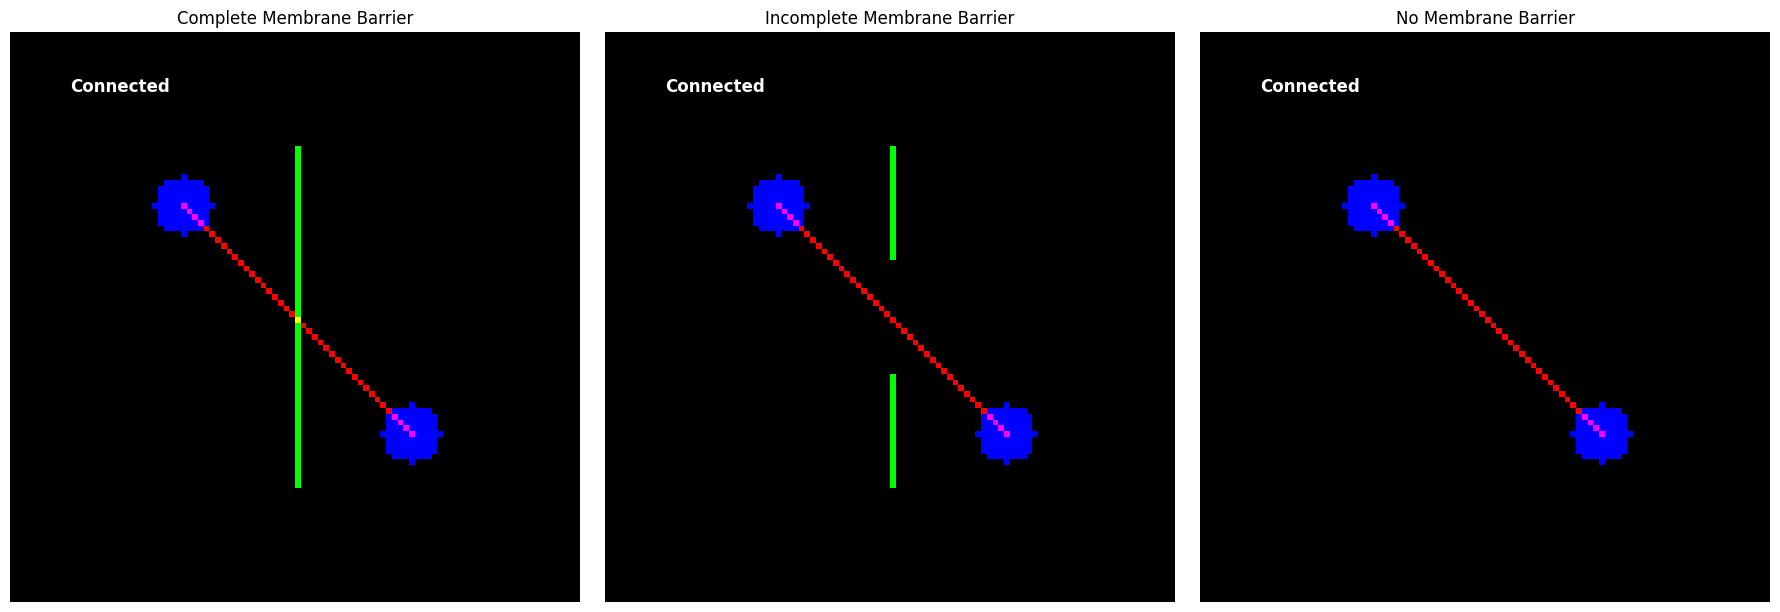


Example 2: Simple Cell Segmentation


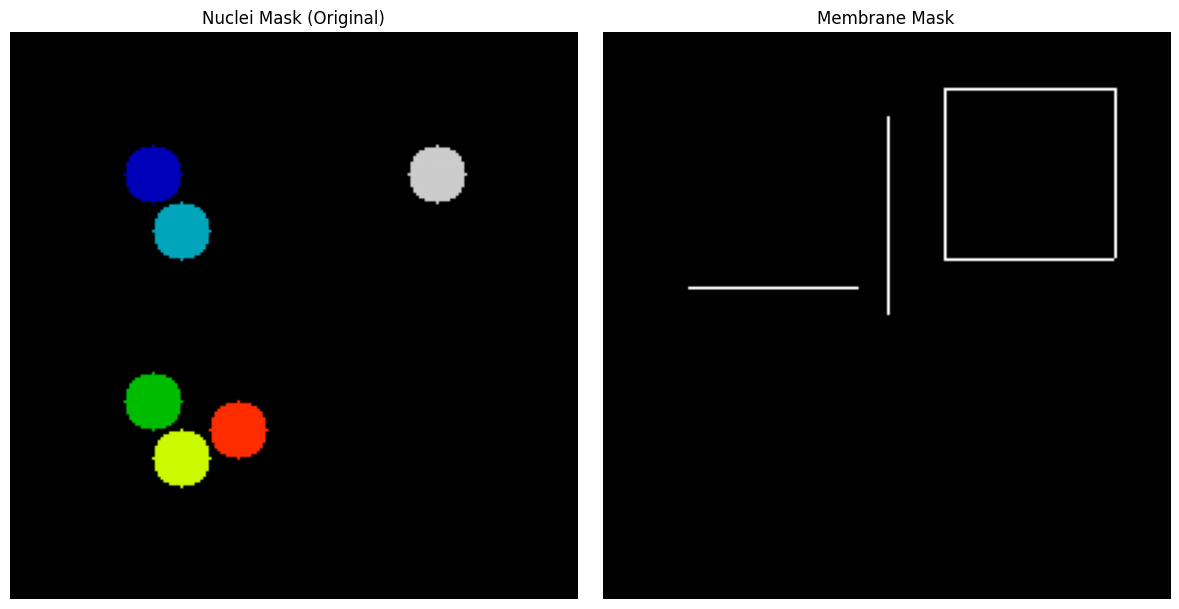

Running simplified cell segmentation...
Merging nuclei 1 and 2 (no membrane barrier)
Merging nuclei 3 and 4 (no membrane barrier)
Merging nuclei 3 and 5 (no membrane barrier)


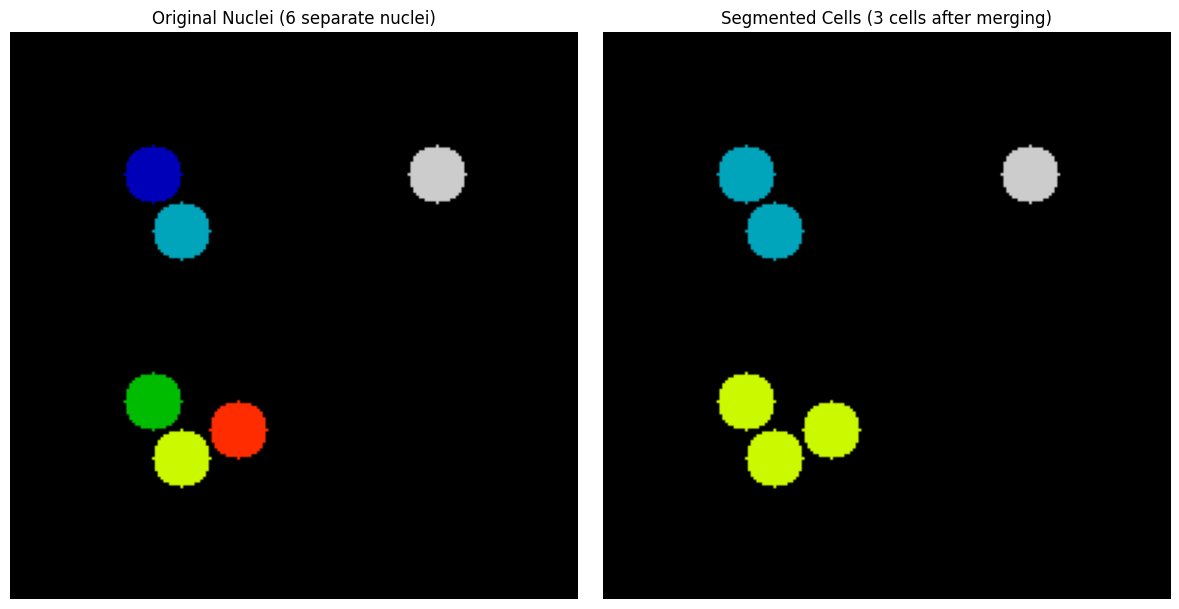


Example 3: Corridor and Cross-Section Visualization


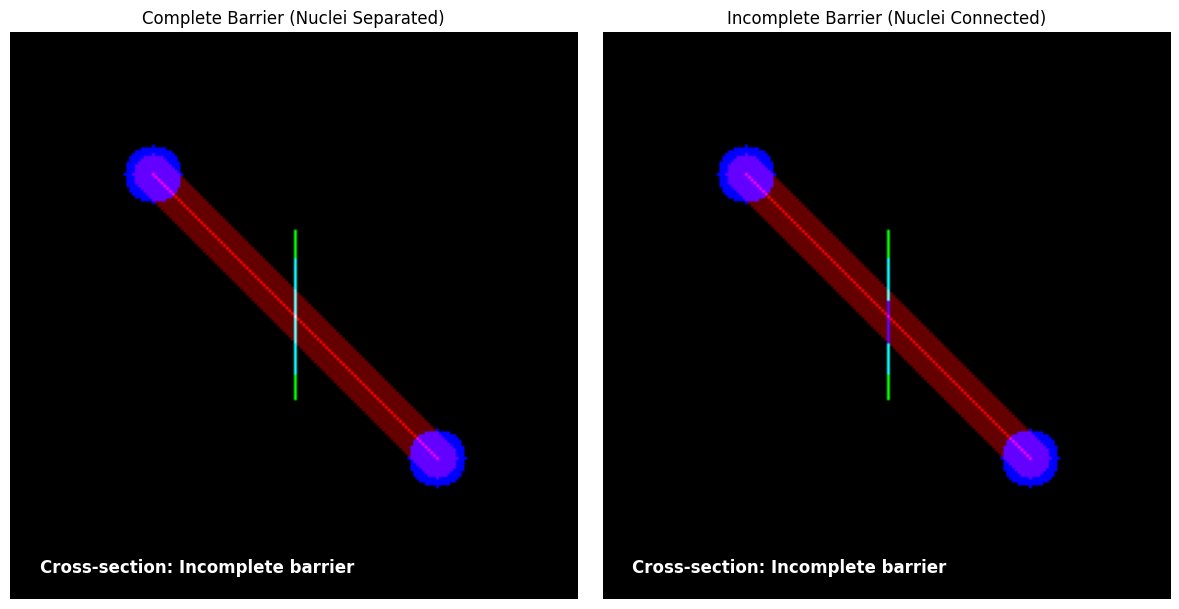

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import binary_dilation

# Basic manual drawing functions (no dependencies on scikit-image)
def draw_line(y0, x0, y1, x1):
    """Manual implementation of Bresenham's line algorithm"""
    points = []

    dx = abs(x1 - x0)
    dy = abs(y1 - y0)
    sx = 1 if x0 < x1 else -1
    sy = 1 if y0 < y1 else -1
    err = dx - dy

    while True:
        points.append((y0, x0))
        if x0 == x1 and y0 == y1:
            break
        e2 = 2 * err
        if e2 > -dy:
            err -= dy
            x0 += sx
        if e2 < dx:
            err += dx
            y0 += sy

    return points

def draw_circle(img, center_y, center_x, radius, color=1):
    """Draw a filled circle using a simple distance calculation"""
    h, w = img.shape[0], img.shape[1]

    for y in range(max(0, center_y - radius), min(h, center_y + radius + 1)):
        for x in range(max(0, center_x - radius), min(w, center_x + radius + 1)):
            if (y - center_y)**2 + (x - center_x)**2 <= radius**2:
                if len(img.shape) == 3:  # RGB image
                    img[y, x] = color
                else:  # Grayscale or mask
                    img[y, x] = color

    return img

def create_disk_structure(radius):
    """Create a disk-shaped structuring element for dilation"""
    y, x = np.ogrid[-radius:radius+1, -radius:radius+1]
    disk = x*x + y*y <= radius*radius
    return disk

# Example 1: Basic membrane interruption check
def example1_membrane_check():
    """
    Create a simple example to demonstrate the membrane interruption check
    between two nuclei centroids.
    """
    # Create a blank image (100x100)
    img_size = 100
    membrane = np.zeros((img_size, img_size), dtype=np.uint8)

    # Create two nuclei centroids
    nucleus1 = (30, 30)
    nucleus2 = (70, 70)

    # Draw a line between the nuclei (this represents the path we're checking)
    line_points = draw_line(nucleus1[0], nucleus1[1], nucleus2[0], nucleus2[1])

    # Draw a membrane barrier (three scenarios)
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    # Scenario 1: Complete membrane barrier
    membrane1 = membrane.copy()
    # Draw a vertical membrane line
    membrane1[20:80, 50] = 1

    # Scenario 2: Incomplete membrane barrier
    membrane2 = membrane.copy()
    # Draw a partial membrane line
    membrane2[20:40, 50] = 1
    membrane2[60:80, 50] = 1

    # Scenario 3: No membrane barrier
    membrane3 = membrane.copy()

    # Visualize all three scenarios
    for i, (mem, title) in enumerate([
        (membrane1, "Complete Membrane Barrier"),
        (membrane2, "Incomplete Membrane Barrier"),
        (membrane3, "No Membrane Barrier")
    ]):
        # Create RGB visualization
        vis = np.zeros((img_size, img_size, 3), dtype=np.uint8)

        # Nuclei in blue
        draw_circle(vis, nucleus1[0], nucleus1[1], 5, color=[0, 0, 255])
        draw_circle(vis, nucleus2[0], nucleus2[1], 5, color=[0, 0, 255])

        # Path in red
        for y, x in line_points:
            vis[y, x, 0] = 255

        # Membrane in green
        vis[mem > 0, 1] = 255

        # Draw the result
        axes[i].imshow(vis)
        axes[i].set_title(title)
        axes[i].axis('off')

        # Determine if there's a complete interrupt
        barrier_status = "Interrupted" if check_simple_barrier(nucleus1, nucleus2, mem) else "Connected"
        axes[i].text(10, 10, barrier_status, color='white', fontsize=12, weight='bold')

    plt.tight_layout()
    plt.show()

def check_simple_barrier(point1, point2, membrane_image):
    """
    Simplified version of the membrane interruption check.
    Returns True if there's a complete barrier interrupting the path.
    """
    # Create a line between the points
    line_points = draw_line(point1[0], point1[1], point2[0], point2[1])

    # Check each point on the line for membrane presence
    for i in range(1, len(line_points)-1):  # Skip the endpoints (nuclei)
        y, x = line_points[i]
        if membrane_image[y, x] > 0:
            # Check if membrane creates a complete barrier at this point
            # Calculate direction vector of the line
            prev_y, prev_x = line_points[i-1]
            next_y, next_x = line_points[i+1]
            dx = next_x - prev_x
            dy = next_y - prev_y

            # Perpendicular vector
            perp_x, perp_y = -dy, dx
            norm = np.sqrt(perp_x**2 + perp_y**2)
            perp_x, perp_y = perp_x/norm, perp_y/norm

            # Check if there's a continuous membrane barrier perpendicular to the path
            barrier_count = 0
            max_run = 0
            current_run = 0

            for j in range(-5, 6):  # Check 11 points across
                check_y = int(y + j * perp_y)
                check_x = int(x + j * perp_x)

                # Ensure within bounds
                if (0 <= check_y < membrane_image.shape[0] and
                    0 <= check_x < membrane_image.shape[1]):
                    if membrane_image[check_y, check_x] > 0:
                        barrier_count += 1
                        current_run += 1
                        max_run = max(max_run, current_run)
                    else:
                        current_run = 0

            # If we have a continuous run of membrane pixels that's at least
            # 80% of the points we checked, consider it a barrier
            if max_run >= 0.8 * 11:  # 11 is the number of points we check
                return True

    return False

# Example 2: Simple cell segmentation with synthetic data
def example2_cell_segmentation():
    """
    Create a synthetic image with multiple nuclei and membranes,
    then run a simplified version of the segmentation algorithm.
    """
    # Create a blank image (200x200)
    img_size = 200
    nuclei_mask = np.zeros((img_size, img_size), dtype=np.int32)
    membrane = np.zeros((img_size, img_size), dtype=np.uint8)

    # Create 6 nuclei in 3 cells
    nuclei_positions = [
        # Cell 1 (2 nuclei)
        (50, 50),
        (70, 60),

        # Cell 2 (3 nuclei)
        (130, 50),
        (150, 60),
        (140, 80),

        # Cell 3 (1 nucleus)
        (50, 150)
    ]

    # Draw nuclei
    for i, pos in enumerate(nuclei_positions, 1):
        draw_circle(nuclei_mask, pos[0], pos[1], 10, color=i)

    # Draw cell membranes
    # Membrane between Cell 1 and Cell 2
    membrane[30:100, 100] = 1

    # Membrane around Cell 3 (approximated with a simple square)
    membrane[20:80, 120:180] = 0  # Clear any previous membrane
    # Top, bottom, left, right of a square around nucleus 6
    membrane[20, 120:180] = 1  # Top
    membrane[80, 120:180] = 1  # Bottom
    membrane[20:80, 120] = 1  # Left
    membrane[20:80, 180] = 1  # Right

    # Membrane between Cell 1 and bottom of image
    membrane[90, 30:90] = 1

    # Visualize the input data
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    # Nuclei mask visualization
    axes[0].imshow(nuclei_mask, cmap='nipy_spectral')
    axes[0].set_title('Nuclei Mask (Original)')
    axes[0].axis('off')

    # Membrane visualization
    axes[1].imshow(membrane, cmap='gray')
    axes[1].set_title('Membrane Mask')
    axes[1].axis('off')

    plt.tight_layout()
    plt.show()

    # Run simplified cell segmentation
    print("Running simplified cell segmentation...")
    cell_mask = simplified_cell_segmentation(nuclei_mask, membrane)

    # Visualize the results
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    # Original nuclei
    axes[0].imshow(nuclei_mask, cmap='nipy_spectral')
    axes[0].set_title('Original Nuclei (6 separate nuclei)')
    axes[0].axis('off')

    # Segmented cells
    axes[1].imshow(cell_mask, cmap='nipy_spectral')
    axes[1].set_title('Segmented Cells (3 cells after merging)')
    axes[1].axis('off')

    plt.tight_layout()
    plt.show()

def simplified_cell_segmentation(nuclei_mask, membrane):
    """
    A simplified version of the cell segmentation algorithm.
    Merges nuclei based on proximity and membrane barriers.
    """
    # Get nuclei centroids
    nuclei_props = {}
    for label_id in range(1, nuclei_mask.max() + 1):
        mask = nuclei_mask == label_id
        y_coords, x_coords = np.where(mask)
        centroid = (int(y_coords.mean()), int(x_coords.mean()))
        nuclei_props[label_id] = {'centroid': centroid}

    # Create a copy for the result
    cell_mask = nuclei_mask.copy()

    # Try to merge all pairs of nuclei
    nucleus_ids = list(nuclei_props.keys())
    merge_map = {i: i for i in nucleus_ids}  # ID of merged cell for each nucleus

    # Process all possible pairs
    for i in range(len(nucleus_ids)):
        for j in range(i+1, len(nucleus_ids)):
            id1, id2 = nucleus_ids[i], nucleus_ids[j]

            # Skip if already merged
            if merge_map[id1] == merge_map[id2]:
                continue

            # Get centroids
            centroid1 = nuclei_props[id1]['centroid']
            centroid2 = nuclei_props[id2]['centroid']

            # Calculate distance
            dist = np.sqrt((centroid1[0] - centroid2[0])**2 + (centroid1[1] - centroid2[1])**2)

            # Only consider nuclei within a certain distance
            if dist < 50:  # Distance threshold
                # Check for membrane barrier
                if not check_simple_barrier(centroid1, centroid2, membrane):
                    # No barrier - merge the nuclei
                    print(f"Merging nuclei {id1} and {id2} (no membrane barrier)")

                    # Always merge to the lower ID
                    merge_from = max(merge_map[id1], merge_map[id2])
                    merge_to = min(merge_map[id1], merge_map[id2])

                    # Update the cell mask
                    cell_mask[cell_mask == merge_from] = merge_to

                    # Update merge map
                    for nuc_id in nucleus_ids:
                        if merge_map[nuc_id] == merge_from:
                            merge_map[nuc_id] = merge_to

    # Relabel to have consecutive IDs
    unique_labels = np.unique(cell_mask)
    unique_labels = unique_labels[unique_labels != 0]  # Exclude background

    # Create a new output array with consecutive labels
    output = np.zeros_like(cell_mask)
    for new_label, old_label in enumerate(unique_labels, 1):
        output[cell_mask == old_label] = new_label

    return output

# Example 3: Visualizing the corridor and cross-section concept
def example3_corridor_visualization():
    """
    Visualize the corridor and cross-section checking mechanism.
    """
    # Create a blank image
    img_size = 200
    membrane = np.zeros((img_size, img_size), dtype=np.uint8)

    # Create two nuclei positions
    nucleus1 = (50, 50)
    nucleus2 = (150, 150)

    # Draw a line between them
    line_points = draw_line(nucleus1[0], nucleus1[1], nucleus2[0], nucleus2[1])

    # Create a corridor along this line
    corridor_width = 15
    corridor = np.zeros((img_size, img_size), dtype=bool)
    for y, x in line_points:
        # Create a small disk at each point along the line
        disk = create_disk_structure(corridor_width//2)
        h, w = disk.shape
        h2, w2 = h//2, w//2

        # Calculate bounds for placing the disk
        y_min = max(0, y - h2)
        y_max = min(img_size, y + h2 + 1)
        x_min = max(0, x - w2)
        x_max = min(img_size, x + w2 + 1)

        # Calculate bounds for extracting the disk
        dy_min = max(0, h2 - y)
        dy_max = min(h, img_size - y + h2)
        dx_min = max(0, w2 - x)
        dx_max = min(w, img_size - x + w2)

        # Place the disk in the corridor
        corridor[y_min:y_max, x_min:x_max] |= disk[dy_min:dy_max, dx_min:dx_max]

    # Add membranes (two scenarios)
    # 1. Complete barrier
    membrane1 = membrane.copy()
    membrane1[70:130, 100] = 1  # Vertical line that completely crosses the corridor

    # 2. Incomplete barrier
    membrane2 = membrane.copy()
    membrane2[70:95, 100] = 1   # Partial barrier (top)
    membrane2[110:130, 100] = 1 # Partial barrier (bottom)

    # Visualize
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    for i, (mem, title) in enumerate([
        (membrane1, "Complete Barrier (Nuclei Separated)"),
        (membrane2, "Incomplete Barrier (Nuclei Connected)")
    ]):
        # Create RGB visualization
        vis = np.zeros((img_size, img_size, 3), dtype=np.uint8)

        # Nuclei in blue
        draw_circle(vis, nucleus1[0], nucleus1[1], 10, color=[0, 0, 255])
        draw_circle(vis, nucleus2[0], nucleus2[1], 10, color=[0, 0, 255])

        # Corridor in semi-transparent red
        red_overlay = np.zeros_like(vis)
        red_overlay[corridor, 0] = 100  # Lower intensity for corridor

        # Membrane in green
        vis[mem > 0, 1] = 255

        # Combine
        vis = vis + red_overlay
        vis = np.clip(vis, 0, 255)

        # Line in bright red
        for y, x in line_points:
            vis[y, x, 0] = 255

        # Draw cross-section at the barrier point
        cross_point = (100, 100)
        cross_line = draw_line(80, 100, 120, 100)  # Vertical cross-section
        for y, x in cross_line:
            vis[y, x, 2] = 255  # Blue line for cross-section

        # Draw the result
        axes[i].imshow(vis)
        axes[i].set_title(title)
        axes[i].axis('off')

        # Check if barrier interrupts path
        barrier_status = check_cross_section_simple(cross_point, (0, 1), mem, corridor_width)
        status_text = "Cross-section: Complete barrier" if barrier_status else "Cross-section: Incomplete barrier"
        axes[i].text(10, 190, status_text, color='white', fontsize=12, weight='bold')

    plt.tight_layout()
    plt.show()

def check_cross_section_simple(point, perp_vector, membrane_image, width):
    """
    Simplified version of cross-section check.
    Returns True if membrane forms a complete barrier across the corridor.
    """
    y, x = point
    dy, dx = perp_vector
    half_width = width // 2

    # Count membrane pixels across the cross-section
    membrane_run = 0
    max_run = 0

    for i in range(-half_width, half_width + 1):
        # Calculate point coordinates along perpendicular line
        cy = int(y + i * dy)
        cx = int(x + i * dx)

        # Check if point has membrane
        if (0 <= cy < membrane_image.shape[0] and
            0 <= cx < membrane_image.shape[1]):
            if membrane_image[cy, cx] > 0:
                membrane_run += 1
                max_run = max(max_run, membrane_run)
            else:
                membrane_run = 0

    # Consider it interrupted if the membrane run is at least 80% of corridor width
    return max_run >= 0.8 * width

if __name__ == "__main__":
    print("Example 1: Basic Membrane Interruption Check")
    example1_membrane_check()

    print("\nExample 2: Simple Cell Segmentation")
    example2_cell_segmentation()

    print("\nExample 3: Corridor and Cross-Section Visualization")
    example3_corridor_visualization()